In [392]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pck
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix

## Funciones

In [196]:
def WOE_Categoricas (df, lst, target = 'play_count'):
      
    for v in lst:
        aux = df[[v, target]].copy()
        aux['n'] = 1
        aux = aux.pivot_table(
            index=v, 
            columns=target, 
            aggfunc='count', 
            observed=False
        )
        aux.columns = aux.columns.droplevel()
        aux.reset_index(inplace=True)
        for i in range(2):
            aux[i] = aux[i].fillna(0)
            aux[i] /= aux[i].sum()
        
        aux['woe'] = np.log((aux[0] / (aux[1] + 1e-10)) + 1e-10)
        df = df.merge(aux[[v, 'woe']], how='inner', on=v)
        df.rename(columns={'woe': f'W_{v}'}, inplace=True)
    
    return df

In [197]:
def WOE_Numericas(df, lst_col, target_column='play_count'):
    lst = []
    for l in lst_col:
        best_iv = 0
        bestk = 0
        
        for k in range(2, 10):
            aux = df[[l, target_column]].copy()
            
            aux[l] = pd.cut(aux[l], bins=k, include_lowest=True).astype(str)
            aux['n'] = 1
           
            aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
            aux_pivot.columns = aux_pivot.columns.droplevel()
            aux_pivot.reset_index(inplace=True)
            
           
            for i in range(2):
                aux_pivot[i] /= aux_pivot[i].sum()
            
        
            aux_pivot['WOE'] = np.log(aux_pivot[0] / aux_pivot[1])
            aux_pivot['IV'] = aux_pivot['WOE'] * (aux_pivot[0] - aux_pivot[1])
            
           
            current_iv = aux_pivot['IV'].sum()
            if (current_iv > best_iv) and (~np.isinf(current_iv)):
                best_iv = current_iv
                bestk = k
    
        print(f"{l} IV: {best_iv:.4f}, Bins: {bestk}")
        if best_iv >= 0.02:
            lst.append(l)
        
        aux = df[[l, target_column]].copy()
        aux[l] = pd.cut(aux[l], bins=bestk, include_lowest=True).astype(str)
        aux['n'] = 1
        
        aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
        aux_pivot.columns = aux_pivot.columns.droplevel()
        aux_pivot.reset_index(inplace=True)
        
        for i in range(2):
            aux_pivot[i] /= aux_pivot[i].sum()
        
        aux_pivot['WOE'] = np.log(aux_pivot[0] / aux_pivot[1])
        aux_pivot['WOE'] = aux_pivot['WOE'].fillna(0)
        
        df[l] = pd.cut(df[l], bins=bestk, include_lowest=True).astype(str)
        df = df.merge(aux_pivot[['WOE', l]], how='inner', on=l)
        df.rename(columns={'WOE': f'w_{l}'}, inplace=True)
    
    return df, lst



## Analisis de datos

In [198]:
summ = pd.read_csv('datos/summary.csv')

In [199]:
summ

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
0,TRJPTGQ128F42A2187,SOIYHHS12A8C13E7B5,0.452,0.000,0.556,0.0,2007,141.66159,1.000,Don't Cry,141.662,22050,4,103.085,ARJ5FD21187FB43F12,Mavado,0.520784,0,Gangsta For Life: The Symphony Of David Brooks,-5.816
1,TRZWFET128F425BF9E,SONEJET12A8C137D3E,0.669,0.000,0.679,0.0,2005,354.69016,0.529,Gypsy Funeral: Hark! From The Tombs Of Doleful...,348.253,22050,1,123.153,ARH3CTU1187FB365C7,Miasma & The Carousel Of Headless Horses,0.346908,9,Perils,-11.137
2,TRNTAMF128F14618CA,SOPAGVA12AF729F018,0.551,0.000,0.672,0.0,2001,338.44200,1.000,Trade Money,327.529,22050,4,162.540,AR0CANF1187B9AF35F,Dilated Peoples,0.457841,7,Expansion Team,-5.199
3,TRALQGQ128F427E682,SODZLJT12A8C13BD4C,0.354,0.000,0.378,0.0,2004,202.37016,1.000,Me Han Vuelto Loca,200.220,22050,4,101.978,ARKE6XC1187B991839,Merche,0.406329,6,Autentica,-2.756
4,TRLOUXS128F92D963F,SOXWPNT12AAF3B270E,0.761,0.000,0.615,0.0,2005,315.58485,0.719,Riders On The Storm,288.142,22050,4,108.992,AR2TT8P1187B9B624D,O'2L,0.291499,9,Doyle's Brunch,-8.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,TRGWRQD128F4298D89,SOMYXHV12A8C13BA11,0.355,0.496,0.032,0.0,1998,209.16200,0.260,arm (Album Version),206.495,22050,4,90.024,AR4CO001187FB4731E,the feelers,0.486442,11,Supersystem,-6.153
19996,TRIPSRA128F931DBAA,SOHOYEM12AB017F833,0.407,0.000,0.353,0.0,2007,90.95791,0.000,Raw Diamond,90.958,22050,4,165.282,ARVRTDI1187B99D797,Baby Grandmothers,0.343689,0,Baby Grandmothers,-5.540
19997,TRSYCMI12903CE007B,SOYSKTB12A58A7B126,0.526,0.000,0.730,0.0,2005,154.67057,0.542,Boom Boom Boom East Blues,154.671,22050,4,190.921,ARCWZP81187FB40E42,Hillstomp,0.425443,2,The Woman That Ended The World,-8.800
19998,TRKVYMQ128F9303EB5,SODWMOZ12A8C13D1CE,0.409,2.682,0.749,0.0,2001,191.29424,0.767,Serenata,177.308,22050,5,139.339,ARJMB691187FB54124,Luciano Pavarotti,0.496486,7,A Song to Remember,-17.083


In [200]:
len(summ['energy'].value_counts())

1

In [201]:
summ['energy'].value_counts()

energy
0.0    20000
Name: count, dtype: int64

In [202]:
aud_feat = pd.read_csv('datos/audio_features.csv')

In [203]:
pd.set_option('display.max_columns', None)
aud_feat

,analysis_sample_rate,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,track_id,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness
0,44100,128056,0,60.081612,0,-14.896189,22050,mp3,mix,9b2010d602420c02fd513c4bd79f0e1a,TRLCHOG12903CBE201,0.728646,0.616806,2.266771e-09,0.999996,0.075123,0.683977,0.510561,0.103477,0.004121,0.217572,0.294421,0.002060
1,44100,128056,0,60.029366,0,-4.654913,22050,mp3,mix,b8130f7ef3c9b28b43718311a851401f,TREQXBJ128F934E3CE,0.017633,0.752542,9.705600e-01,0.000016,0.173669,0.044266,0.002073,0.990112,0.976110,0.394722,0.994963,0.996827
2,44100,128056,0,60.081612,0,-8.621744,22050,mp3,mix,58f66795976e8a247cfc7b236df8ecfa,TRGRCXR12903CFD7CD,0.167005,0.073315,9.027991e-01,0.116882,0.156126,0.461002,0.079624,0.635178,0.797037,0.962334,0.921192,0.001401
3,44100,128000,0,60.081635,0,-9.171843,44100,mp3,mix,cfeec8a419264b103f2b081527d3c2da,TRTOZPV128F92D71AC,0.694412,0.003315,4.715616e-01,0.034741,0.532327,0.500000,0.298832,0.218486,0.653770,0.456679,0.970731,0.012652
4,44100,128111,0,30.040817,0,-9.060616,44100,mp3,mix,7add0fbccf6ff22900efeeb9ead8a59d,TRKNISH128F42627EA,0.226367,0.717184,3.517592e-02,0.682841,0.190215,0.651303,0.684198,0.255997,0.102924,0.248094,0.973870,0.383030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19659,44100,128111,0,30.040817,0,-7.517710,44100,mp3,mix,3b0a7503ed792e5d778893923bfa6804,TRDPAJY128F92FC55C,0.168015,0.987025,3.540825e-01,0.055762,0.635024,0.355624,0.291486,0.760798,0.519728,0.965883,0.913866,0.026887
19660,44100,128111,0,30.090929,0,-13.033228,22050,mp3,mix,b18aade4d623eb271e41ebab049a2efe,TRLMMXC128E0788922,0.163524,0.640598,8.652153e-03,0.162394,0.306545,0.318722,0.167853,0.536974,0.337150,0.573431,0.829188,0.507271
19661,44100,128111,0,30.040817,0,-16.879805,44100,mp3,mix,635579dc324625ee909593a8c4591a5d,TRUPXCC12903CC4E16,0.945337,0.023581,3.361252e-02,0.921268,0.229842,0.543545,0.678771,0.031759,0.065743,0.679156,0.679754,0.000847
19662,44100,128056,0,60.081612,0,-12.494322,22050,mp3,mix,339dec54456a68db26f9b962c69c08d4,TRQVIJY12903CB6BED,0.117992,0.849533,8.022478e-01,0.018567,0.232288,0.164193,0.063216,0.974034,0.728285,0.249303,0.549528,0.007322


In [204]:
summ[summ['track_id'] == 'TRAVDUU128F424D590']

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
3088,TRAVDUU128F424D590,SOCOHKB12A6D4FD6A1,0.634,0.311,0.736,0.0,2008,264.93342,0.334,Voiman vartijat,264.933,22050,3,181.992,ARW4CA41187FB3F152,Ter\xc3\xa4sbetoni,0.420238,11,Myrskyntuoja,-2.302


In [205]:
aud_feat.isnull().sum()

analysis_sample_rate    0
bit_rate                0
equal_loudness          0
length                  0
lossless                0
replay_gain             0
sample_rate             0
codec                   0
downmix                 0
md5_encoded             0
track_id                0
danceability            0
femaleness              0
acousticness            0
aggressiveness          0
electronicity           0
happiness               0
festiveness             0
relaxation              0
sadness                 0
brightness              0
tonality                0
insrumentalness         0
dtype: int64

In [206]:
len(aud_feat['danceability'].value_counts())

19135

In [207]:
len(aud_feat['happiness'].value_counts())

19429

In [208]:
len(aud_feat['festiveness'].value_counts())

19464

In [209]:
len(aud_feat['relaxation'].value_counts())

19449

In [210]:
len(aud_feat['sadness'].value_counts())

19531

In [211]:
summ[summ['artist_hotttnesss'] == summ['artist_hotttnesss'].max()]

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness
9183,TRORZPX128F42ACE6B,SOKBRVC12A81C204DE,0.751,0.083,0.784,0.0,2007,313.28608,1.000,Drunk and Hot Girls,308.558,22050,3,165.558,ARRH63Y1187FB47783,Kanye West / Mos Def,1.082503,10,Graduation,-7.742
13831,TRDJSBZ128E0791597,SOKXNNH12A67020A46,0.512,0.063,0.532,0.0,2009,448.05179,0.795,We Major,448.052,22050,4,99.314,ARRH63Y1187FB47783,Kanye West / Nas / Really Doe,1.082503,11,Late Registration,-4.313
16104,TRPBGJR128F92FA7FE,SOPIJAI12AB01838F8,0.706,0.000,1.000,0.0,2008,262.92200,0.954,Welcome To Heartbreak,259.030,22050,4,192.029,ARRH63Y1187FB47783,Kanye West / Kid Cudi,1.082503,7,808s & Heartbreak,-12.208


In [212]:
df =  pd.merge(summ, aud_feat, on = 'track_id', how  = 'outer')

In [213]:
df.isna().sum()

track_id                        0
song_id                      2556
mode_confidence              2556
end_of_fade_in               2556
key_confidence               2556
energy                       2556
year                         2556
duration                     2556
time_signature_confidence    2556
title                        2556
start_of_fade_out            2556
analysis_sample_rate_x       2556
time_signature               2556
tempo                        2556
artist_id                    2556
artist_name                  2556
artist_hotttnesss            2556
key                          2556
release                      2556
loudness                     2556
analysis_sample_rate_y       2892
bit_rate                     2892
equal_loudness               2892
length                       2892
lossless                     2892
replay_gain                  2892
sample_rate                  2892
codec                        2892
downmix                      2892
md5_encoded   

In [214]:
song_play_count = pd.read_csv('datos/song_play_count.csv')

In [215]:
song_play_count

,user_id,song_id,play_count
0,60187,SOYMXMF12A6D4FCDA2,1
1,11193,SOIYNJG12AB01810B2,2
2,67953,SOYDTRQ12AF72A3D61,5
3,132173,SOLGFKA12A6D4F7B9A,1
4,578451,SOTDPWU12A8AE47B2B,4
...,...,...,...
1517636,129566,SOIPSLZ12A8C140561,1
1517637,101507,SOCIDVO12A58A7DDA4,2
1517638,573589,SOGXDRM12A6D4F7CE0,1
1517639,469534,SOIDDNJ12AC9071B90,1


In [216]:
df_trgt = song_play_count.groupby('song_id')['play_count'].sum()

In [217]:
df_trgt

song_id
SOAABDH12A6D4F7658       9
SOAAGDJ12A8C13A1C6     661
SOAAGQU12AB01843A8       1
SOAALEG12A58A79808     282
SOAAMTH12AF729D4E5    1021
                      ... 
SOZZTQU12AB017FAEE     159
SOZZWHT12A8C142264     125
SOZZXQJ12AB0184460       4
SOZZYDH12AAF3B31AF       7
SOZZZHR12A8C138D52       9
Name: play_count, Length: 10370, dtype: int64

In [218]:
df_trgt = df_trgt.reset_index()

In [219]:
df_trgt

,song_id,play_count
0,SOAABDH12A6D4F7658,9
1,SOAAGDJ12A8C13A1C6,661
2,SOAAGQU12AB01843A8,1
3,SOAALEG12A58A79808,282
4,SOAAMTH12AF729D4E5,1021
...,...,...
10365,SOZZTQU12AB017FAEE,159
10366,SOZZWHT12A8C142264,125
10367,SOZZXQJ12AB0184460,4
10368,SOZZYDH12AAF3B31AF,7


In [220]:
df = pd.merge(df, df_trgt, on = 'song_id', how = 'outer')

In [221]:
df.isnull().sum()

track_id                         0
song_id                       2556
mode_confidence               2556
end_of_fade_in                2556
key_confidence                2556
energy                        2556
year                          2556
duration                      2556
time_signature_confidence     2556
title                         2556
start_of_fade_out             2556
analysis_sample_rate_x        2556
time_signature                2556
tempo                         2556
artist_id                     2556
artist_name                   2556
artist_hotttnesss             2556
key                           2556
release                       2556
loudness                      2556
analysis_sample_rate_y        2892
bit_rate                      2892
equal_loudness                2892
length                        2892
lossless                      2892
replay_gain                   2892
sample_rate                   2892
codec                         2892
downmix             

In [222]:
df

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
0,TRMTWOF128F147EA43,SOAABDH12A6D4F7658,0.893,0.277,0.830,0.0,1999.0,215.14404,0.299,Prefiero,206.002,22050.0,4.0,205.734,AR8EDG51187FB41A08,Gary Hobbs,0.389766,7.0,Despues De Ti,-9.103,44100.0,64057.0,0.0,60.029366,0.0,-10.189594,22050.0,mp3,mix,5bfeb8b1e95729e6511e029d17ca052d,0.418873,0.635057,3.821953e-01,0.066103,0.142944,0.795350,0.321348,0.544195,0.645960,0.969493,0.972927,0.019999,9.0
1,TRTKIPU128F4295E86,SOAACBD12A8C13C8C4,0.986,5.846,0.892,0.0,2004.0,292.70159,0.469,Schutz\xc3\xa4ngel,280.602,22050.0,4.0,86.842,ARPEHXU1187FB459BF,Pl\xc3\xbcsch,0.342917,2.0,Sidefiin,-11.591,44100.0,128111.0,0.0,30.040817,0.0,-8.736227,44100.0,mp3,mix,aba0901be553865b01971b194d75aabf,0.470389,0.698749,9.649308e-01,0.025333,0.012969,0.453471,0.029834,0.990617,0.977490,0.974045,0.994053,0.000029,NaN
2,TRXDLKB128F14A0D37,SOAACTO12A6D4FBC75,0.612,0.000,0.607,0.0,1997.0,419.05587,0.360,Shelter,414.465,22050.0,4.0,139.998,ARXONP51187B9AF54A,Mijk Van Dijk,0.393413,1.0,Shelter,-6.768,44100.0,64109.0,0.0,30.014671,0.0,-12.918201,22050.0,mp3,mix,da9dac82d4f714fdf985f26745b8d838,0.519934,0.764675,2.732940e-03,0.466219,0.969136,0.309143,0.838269,0.053038,0.023681,0.664507,0.011120,0.025571,NaN
3,TRLNIIK12903CD040B,SOAADJB12AB0188C24,0.614,0.259,0.885,0.0,1999.0,241.47546,0.000,The One,234.760,22050.0,4.0,127.990,ARRRYGH1187B9B9FE8,Den Harrow,0.395906,11.0,Back From The Future,-6.785,44100.0,128056.0,0.0,60.081612,0.0,-12.370787,22050.0,mp3,mix,0321141e3273f24acef6b733499f1c0f,0.994743,0.923131,1.270489e-02,0.442953,0.821824,0.776063,0.881728,0.073152,0.168183,0.994569,0.826780,0.061254,NaN
4,TRSOAAB128F1498895,SOAAFWR12A6D4F92C1,0.535,0.567,0.423,0.0,2003.0,298.13506,0.537,Come Rain Or Come Shine,285.733,22050.0,3.0,82.071,ARCN61O1187B9ABBE8,Aaron Neville,0.508938,0.0,Nature Boy: The Standards Album,-16.675,44100.0,128000.0,0.0,30.040817,0.0,-6.271719,44100.0,mp3,mix,9aacb42eaadd459de6b346619ba542c7,0.063820,0.077110,9.667940e-01,0.000014,0.156449,0.046899,0.040868,0.981551,0.811426,0.864642,0.941787,0.871637,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,TRZYLMO128EF354C98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,64055.0,0.0,30.040794,0.0,-9.742807,22050.0,mp3,mix,1101a81e46f4bf30f8ff47486284711b,0.998895,0.881488,2.941813e-03,0.826598,0.993948,0.794935,0.832598,0.101857,0.084123,0.026319,0.249012,0.182163,NaN
22552,TRZYQAI128F9329FFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.029366,0.0,-12.194342,22050.0,mp3,mix,12ae1fb352fb0e14005bf9da07790d6c,0.597751,0.170400,2.953405e-03,0.896917,0.917529,0.105743,0.894987,0.301557,0.211276,0.004390,0.288906,0.308543,NaN
22553,TRZZVQO12903CA7F34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-12.197174,22050.0,mp3,mix,f1793679f69c649b3ce4f3744d894668,0.877739,0.220075,3.969250e-01,0.002929,0.072631,0.934857,0.191097,0.180074,0.457773,0.905693,0.811138,0.039957,NaN
22554,TRZZXUC12903CF8108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-14.950634,22050.0,mp3,mix,bdf901299b096d8f427d491956e9f842,0.735522,0.276195,1.275369e-01,0.191142,0.021233,0.903582,0.373696,0.161387,0.160291,0.990295,0.364201,0.939390,NaN


In [223]:
song_genres = pd.read_csv('datos/song_genres.csv')

In [224]:
song_genres

,track_id,main_genre
0,TRSZBVQ128F425D5B6,Rock
1,TRRJNCE128F9319E52,RnB
2,TRIZJQX128F1472163,Folk
3,TRBXBWB128F92F9F2B,Rap
4,TRFBZFH12903CBDABB,Electronic
...,...,...
8411,TRHKNDN128F9320924,Blues
8412,TRGIYIR128F92DCDF1,Rock
8413,TRVFMDX128F42915F2,Punk
8414,TRLWOAY128F933A6A3,Rock


In [225]:
df = pd.merge(df, song_genres, how = 'outer', on = 'track_id')

In [226]:
df.isnull().sum()

track_id                         0
song_id                       4965
mode_confidence               4965
end_of_fade_in                4965
key_confidence                4965
energy                        4965
year                          4965
duration                      4965
time_signature_confidence     4965
title                         4965
start_of_fade_out             4965
analysis_sample_rate_x        4965
time_signature                4965
tempo                         4965
artist_id                     4965
artist_name                   4965
artist_hotttnesss             4965
key                           4965
release                       4965
loudness                      4965
analysis_sample_rate_y        5301
bit_rate                      5301
equal_loudness                5301
length                        5301
lossless                      5301
replay_gain                   5301
sample_rate                   5301
codec                         5301
downmix             

In [227]:
df

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,SOHUOAP12A8AE488E9,0.829,0.000,1.000,0.0,1987.0,491.12771,0.756,Floating,486.034,22050.0,4.0,119.826,ARD842G1187B997376,Blue Rodeo,0.447935,7.0,Outskirts,-8.576,44100.0,128100.0,0.0,33.306122,0.0,-15.267794,44100.0,mp3,mix,7a2ebe6667028eec15458c0c04de2714,0.320790,0.024384,9.004630e-01,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
1,TRAABWE128F93418C0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.029366,0.0,-15.162943,22050.0,mp3,mix,a30730ce15a8f97e893dbd359b51b8ed,0.984246,0.643747,2.006704e-06,0.999608,0.980326,0.059469,0.975727,0.032910,0.004847,0.003837,0.008125,0.036147,NaN,NaN
2,TRAACNS128F14A2DF5,SOBZBAZ12A6D4F8742,0.736,0.200,0.812,0.0,1997.0,168.25424,0.792,Spanish Grease,161.890,22050.0,4.0,127.025,AROUOZZ1187B9ABE51,Willie Bobo,0.379671,8.0,Willie Bobo's Finest Hour,-9.616,44100.0,64028.0,0.0,60.029366,0.0,-9.773314,22050.0,mp3,mix,b1e279a0dc927cd5b5dff28de6b6d2df,0.618978,0.942064,6.634281e-01,0.046902,0.640927,0.457956,0.288112,0.776293,0.813896,0.949835,0.974706,0.188617,NaN,NaN
3,TRAACPE128F421C1B9,SOGNCJP12A58A80271,0.538,0.063,0.381,0.0,1972.0,342.56934,0.353,Do You Finally Need A Friend,333.154,22050.0,3.0,110.189,ARB29H41187B98F0EF,Terry Callier,0.416173,6.0,Occasional Rain,-11.939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RnB
4,TRAACTB12903CAAF15,SOGXHEG12AB018653E,0.402,0.000,0.384,0.0,1992.0,133.32853,0.000,It Makes No Difference Now,130.009,22050.0,1.0,160.839,AR0RCMP1187FB3F427,Billie Jo Spears,0.384611,4.0,20 Of Her Best,-9.983,44100.0,128056.0,0.0,60.029366,0.0,-11.237694,22050.0,mp3,mix,39731fa10f282a2150e5e70506a61215,0.235422,0.954638,1.852035e-01,0.000013,0.071714,0.815497,0.233605,0.410173,0.723580,0.902474,0.954868,0.260661,NaN,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24960,TRZZXUC12903CF8108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,128056.0,0.0,60.081612,0.0,-14.950634,22050.0,mp3,mix,bdf901299b096d8f427d491956e9f842,0.735522,0.276195,1.275369e-01,0.191142,0.021233,0.903582,0.373696,0.161387,0.160291,0.990295,0.364201,0.939390,NaN,NaN
24961,TRZZYOF128F4255016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Age
24962,TRZZZFV128F4259A2B,SOXJZLK12A8AE48D05,0.293,0.955,0.037,0.0,2000.0,297.58649,0.294,Kill All Hippies,294.383,22050.0,5.0,66.394,ARW63XP1187FB5AB99,Primal Scream,0.488099,5.0,XTRMNTR,-6.329,44100.0,128111.0,0.0,30.040817,0.0,-10.148268,44100.0,mp3,mix,2ad6f8fe1e81b081aa365db3f10c9dd2,0.552813,0.766357,2.436607e-02,0.904225,0.665552,0.282454,0.868709,0.029786,0.089039,0.856844,0.725524,0.423473,155.0,NaN
24963,TRZZZQO128E078864C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44100.0,64055.0,0.0,30.066916,0.0,-13.374027,22050.0,mp3,mix,dac4488591d80af59b85a2d9ed4ab608,0.574547,0.450648,5.777591e-07,0.987771,0.814584,0.546908,0.764537,0.082487,0.006817,0.135821,0.234135,0.003976,NaN,NaN


In [228]:
df_mer = df.dropna()

In [229]:
df_mer.isnull().sum()

track_id                     0
song_id                      0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
energy                       0
year                         0
duration                     0
time_signature_confidence    0
title                        0
start_of_fade_out            0
analysis_sample_rate_x       0
time_signature               0
tempo                        0
artist_id                    0
artist_name                  0
artist_hotttnesss            0
key                          0
release                      0
loudness                     0
analysis_sample_rate_y       0
bit_rate                     0
equal_loudness               0
length                       0
lossless                     0
replay_gain                  0
sample_rate                  0
codec                        0
downmix                      0
md5_encoded                  0
danceability                 0
femaleness                   0
acoustic

In [230]:
df_mer.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,time_signature,tempo,artist_hotttnesss,key,loudness,analysis_sample_rate_y,bit_rate,equal_loudness,length,lossless,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
count,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.0,3330.000000,3330.0,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3.330000e+03,3.330000e+03,3330.000000,3330.000000,3330.000000,3.330000e+03,3330.000000,3330.000000
mean,0.471971,0.911983,0.439054,0.0,1999.593093,250.537805,0.527278,240.870660,22050.0,3.663363,125.800729,0.456388,5.279880,-8.953480,44100.0,108075.679580,0.0,46.855027,0.0,-11.358983,29023.153153,4.416050e-01,5.431135e-01,2.743777e-01,4.008949e-01,0.494576,4.660381e-01,4.225352e-01,0.455529,0.349852,0.589916,5.363020e-01,0.246328,467.716817
std,0.191614,2.205328,0.276908,0.0,9.782274,103.604439,0.371293,101.263597,0.0,1.119964,34.270209,0.095505,3.588438,4.577903,0.0,29865.628926,0.0,15.614642,0.0,3.570724,10254.412188,3.834576e-01,3.203668e-01,3.415280e-01,3.808397e-01,0.314047,2.817952e-01,3.019056e-01,0.361275,0.303856,0.361049,3.738967e-01,0.340768,1878.904170
min,0.000000,0.000000,0.000000,0.0,1930.000000,14.863220,0.000000,14.863000,22050.0,0.000000,0.000000,0.000000,0.000000,-41.752000,44100.0,58145.000000,0.0,8.672630,0.0,-20.352661,22050.000000,3.000001e-14,7.190201e-11,4.062316e-12,3.000001e-14,0.000013,6.147993e-10,2.580266e-07,0.000736,0.001810,0.000093,3.000001e-14,0.000002,1.000000
1%,0.000000,0.000000,0.000000,0.0,1968.000000,56.437095,0.000000,54.930080,22050.0,1.000000,50.147350,0.286320,0.000000,-24.349580,44100.0,64028.000000,0.0,29.884060,0.0,-16.897257,22050.000000,7.899662e-11,4.387197e-03,1.136856e-08,4.724511e-07,0.017470,5.149552e-03,1.316717e-03,0.004189,0.006606,0.002551,1.054249e-07,0.000054,1.000000
25%,0.356250,0.000000,0.204250,0.0,1996.000000,192.339142,0.148000,183.131250,22050.0,4.000000,99.973250,0.396474,2.000000,-11.149500,44100.0,64058.000000,0.0,30.040817,0.0,-13.891028,22050.000000,5.275831e-02,2.570719e-01,8.052085e-03,4.297031e-02,0.200964,2.218598e-01,1.287067e-01,0.091735,0.078084,0.223513,1.369093e-01,0.005410,17.000000
50%,0.479000,0.200000,0.455000,0.0,2003.000000,235.336690,0.578500,225.010000,22050.0,4.000000,123.690500,0.447056,5.000000,-7.913000,44100.0,128056.000000,0.0,60.029366,0.0,-12.122363,22050.000000,3.522282e-01,5.613017e-01,7.974853e-02,2.535777e-01,0.476828,4.547744e-01,4.126302e-01,0.390139,0.246993,0.688222,5.904834e-01,0.051168,64.000000
75%,0.600000,0.453000,0.648000,0.0,2006.000000,290.298325,0.879000,278.027250,22050.0,4.000000,147.201500,0.509863,9.000000,-5.659000,44100.0,128111.000000,0.0,60.029366,0.0,-9.572178,44100.000000,8.640895e-01,8.542334e-01,5.107173e-01,8.175596e-01,0.790406,7.047899e-01,6.879548e-01,0.829054,0.605832,0.947904,9.164003e-01,0.405115,251.750000
99%,0.904130,9.202540,1.000000,0.0,2010.000000,559.813818,1.000000,542.902030,22050.0,7.000000,216.406170,0.768767,11.000000,-2.692060,44100.0,128111.000000,0.0,60.133854,0.0,-0.689969,44100.000000,9.999987e-01,9.991403e-01,9.947895e-01,9.999409e-01,0.996431,9.884020e-01,9.658494e-01,0.996411,0.965459,1.000000,9.990849e-01,0.999998,7084.890000
max,1.000000,60.511000,1.000000,0.0,2010.000000,1686.569340,1.000000,1677.125000,22050.0,7.000000,248.441000,1.082503,11.000000,0.709000,44100.0,230322.000000,0.0,310.256317,0.0,38.401222,44100.000000,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999930,9.999999e-01,9.999960e-01,0.999999,0.992247,1.000000,9.999726e-01,1.000000,49119.000000


#### Variables que no sirven: Variables con std = 0, year, codec, downmix, md5_encoded

In [231]:
df_mer['bit_rate'].value_counts()

bit_rate
128056.0    1001
128111.0     978
64028.0      428
64055.0      280
128000.0     258
            ... 
64068.0        1
64115.0        1
128086.0       1
64118.0        1
128062.0       1
Name: count, Length: 77, dtype: int64

In [232]:
df_mer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 24947
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   track_id                   3330 non-null   object 
 1   song_id                    3330 non-null   object 
 2   mode_confidence            3330 non-null   float64
 3   end_of_fade_in             3330 non-null   float64
 4   key_confidence             3330 non-null   float64
 5   energy                     3330 non-null   float64
 6   year                       3330 non-null   float64
 7   duration                   3330 non-null   float64
 8   time_signature_confidence  3330 non-null   float64
 9   title                      3330 non-null   object 
 10  start_of_fade_out          3330 non-null   float64
 11  analysis_sample_rate_x     3330 non-null   float64
 12  time_signature             3330 non-null   float64
 13  tempo                      3330 non-null   float64
 

In [233]:
lst_cont = df_mer.select_dtypes(include = ['float64']).columns

In [234]:
lst_cont

Index(['mode_confidence', 'end_of_fade_in', 'key_confidence', 'energy', 'year',
       'duration', 'time_signature_confidence', 'start_of_fade_out',
       'analysis_sample_rate_x', 'time_signature', 'tempo',
       'artist_hotttnesss', 'key', 'loudness', 'analysis_sample_rate_y',
       'bit_rate', 'equal_loudness', 'length', 'lossless', 'replay_gain',
       'sample_rate', 'danceability', 'femaleness', 'acousticness',
       'aggressiveness', 'electronicity', 'happiness', 'festiveness',
       'relaxation', 'sadness', 'brightness', 'tonality', 'insrumentalness',
       'play_count'],
      dtype='object')

In [235]:
lst_std_z = df_mer[lst_cont].columns[df_mer[lst_cont].std() == 0]

In [236]:
lst_std_z

Index(['energy', 'analysis_sample_rate_x', 'analysis_sample_rate_y',
       'equal_loudness', 'lossless'],
      dtype='object')

In [237]:
df_mer = df_mer.drop(columns = lst_std_z)

In [238]:
df_mer

,track_id,song_id,mode_confidence,end_of_fade_in,key_confidence,year,duration,time_signature_confidence,title,start_of_fade_out,time_signature,tempo,artist_id,artist_name,artist_hotttnesss,key,release,loudness,bit_rate,length,replay_gain,sample_rate,codec,downmix,md5_encoded,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,SOHUOAP12A8AE488E9,0.829,0.000,1.000,1987.0,491.12771,0.756,Floating,486.034,4.0,119.826,ARD842G1187B997376,Blue Rodeo,0.447935,7.0,Outskirts,-8.576,128100.0,33.306122,-15.267794,44100.0,mp3,mix,7a2ebe6667028eec15458c0c04de2714,3.207898e-01,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
7,TRAAEHK128F92C9C79,SOXQUAN12A8C14237B,0.360,0.000,0.328,2000.0,212.74077,0.424,Big Boy Now,204.516,4.0,166.349,ARXDGV71187B990B08,Super Chikan,0.000000,10.0,What You See,-6.469,128056.0,60.029366,-13.997978,22050.0,mp3,mix,21b83200664e09975adc157a1e148870,7.771334e-01,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,15.0,Blues
8,TRAAFOH128E078BD7E,SOMJOMF12A6701DDCA,0.472,1.570,0.365,2004.0,221.98812,0.600,Sold,208.747,4.0,210.102,AR9SWNW1187FB5934B,Imperanon,0.417325,0.0,Stained,-5.040,128111.0,30.040817,-13.311316,44100.0,mp3,mix,d840e9ee93793271850bdc12e6c3f39f,2.643282e-03,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,40.0,Metal
11,TRAAIMO128F92EB778,SOREAWH12AB017BF03,0.554,0.549,0.460,2009.0,209.34485,0.690,Ain't No Secret,199.343,4.0,109.003,ARBTDXS11E2835CEC6,The Alternate Routes,0.427150,0.0,A Sucker's Dream,-4.851,128111.0,30.040794,-14.724085,22050.0,mp3,mix,fa91596b57edf4b84fe2a73395f77daf,1.223387e-01,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,68.0,Rock
18,TRAANSZ128F425DD63,SOGKZXO12A8C13E3EE,0.451,16.179,0.180,2003.0,293.56363,1.000,Stop Coming To My House,278.036,4.0,104.280,ARZ4XS71187B9AEF25,Mogwai,0.544628,2.0,Happy Songs For Happy People,-10.844,64028.0,60.029366,-11.736826,22050.0,mp3,mix,2f7e8d1c5c44ce2f372df3348c067fad,1.231322e-07,0.717061,0.003173,0.941321,0.191615,0.260675,0.353950,0.147476,0.172161,0.390841,0.827491,0.067375,6901.0,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,SOTKJLJ12AB017ECC8,0.376,0.224,0.157,1996.0,249.12934,0.265,No Man's Land,242.196,4.0,141.267,ARD2GXE1187B9A2E26,Mad Professor,0.396205,4.0,Evolution of Dub (Chapter 3),-13.431,128056.0,60.081612,-6.839115,22050.0,mp3,mix,c2887581c8235d1dc72540c48f37f49b,9.999999e-01,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,31.0,Reggae
24939,TRZZIJW128F930B20F,SODMCCG12AB0181001,0.876,0.000,0.969,2002.0,58.77506,0.000,Nature,58.775,1.0,120.005,ARG3O6S1187FB46EAE,The Jelly Jam,0.386984,2.0,The Jelly Jam,-20.022,128057.0,58.801609,-4.788458,22050.0,mp3,mix,88dca06cca6b0f2f4d49da7fda7c4d59,4.300911e-06,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,12.0,Rock
24942,TRZZMHR128F1490F28,SOJSKVA12A6D4F9A4B,0.424,4.458,0.307,2000.0,403.95710,1.000,Pilgrims,398.141,4.0,194.020,AR5CLUM1187FB3C699,United Future Organization,0.358851,10.0,Bon Voyage,-11.977,128111.0,30.040817,-7.450308,44100.0,mp3,mix,c4c32108c8500f7f0aac0b76d2b53baf,7.682232e-01,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,14.0,Electronic
24944,TRZZOUK128F92E3480,SOYRVEE12A8C133BB2,0.529,0.000,0.599,1999.0,213.47220,0.579,Permanent Jet Lag,208.260,4.0,147.557,ARNO8TU1187B9AFE37,Billy Cobham,0.453524,10.0,BY DESIGN,-13.685,128111.0,30.040817,-6.247433,44100.0,mp3,mix,f9cb0630ee5a5969f87782564fa6e82d,2.673960e-01,0.760838,0.048918,0.50

In [239]:
df_mer = df_mer.drop(columns  = ['song_id','title','year', 'artist_id', 'artist_name','release','codec','downmix','md5_encoded'])

In [240]:
df_mer

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,main_genre
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,44100.0,3.207898e-01,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,60.0,Rock
7,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,22050.0,7.771334e-01,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,15.0,Blues
8,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,44100.0,2.643282e-03,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,40.0,Metal
11,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,22050.0,1.223387e-01,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,68.0,Rock
18,TRAANSZ128F425DD63,0.451,16.179,0.180,293.56363,1.000,278.036,4.0,104.280,0.544628,2.0,-10.844,64028.0,60.029366,-11.736826,22050.0,1.231322e-07,0.717061,0.003173,0.941321,0.191615,0.260675,0.353950,0.147476,0.172161,0.390841,0.827491,0.067375,6901.0,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,0.376,0.224,0.157,249.12934,0.265,242.196,4.0,141.267,0.396205,4.0,-13.431,128056.0,60.081612,-6.839115,22050.0,9.999999e-01,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,31.0,Reggae
24939,TRZZIJW128F930B20F,0.876,0.000,0.969,58.77506,0.000,58.775,1.0,120.005,0.386984,2.0,-20.022,128057.0,58.801609,-4.788458,22050.0,4.300911e-06,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,12.0,Rock
24942,TRZZMHR128F1490F28,0.424,4.458,0.307,403.95710,1.000,398.141,4.0,194.020,0.358851,10.0,-11.977,128111.0,30.040817,-7.450308,44100.0,7.682232e-01,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,14.0,Electronic
24944,TRZZOUK128F92E3480,0.529,0.000,0.599,213.47220,0.579,208.260,4.0,147.557,0.453524,10.0,-13.685,128111.0,30.040817,-6.247433,44100.0,2.673960e-01,0.760838,0.048918,0.508864,0.788453,0.262665,0.684977,0.189497,0.187421,0.721574,0.874544,0.848592,86.0,Jazz


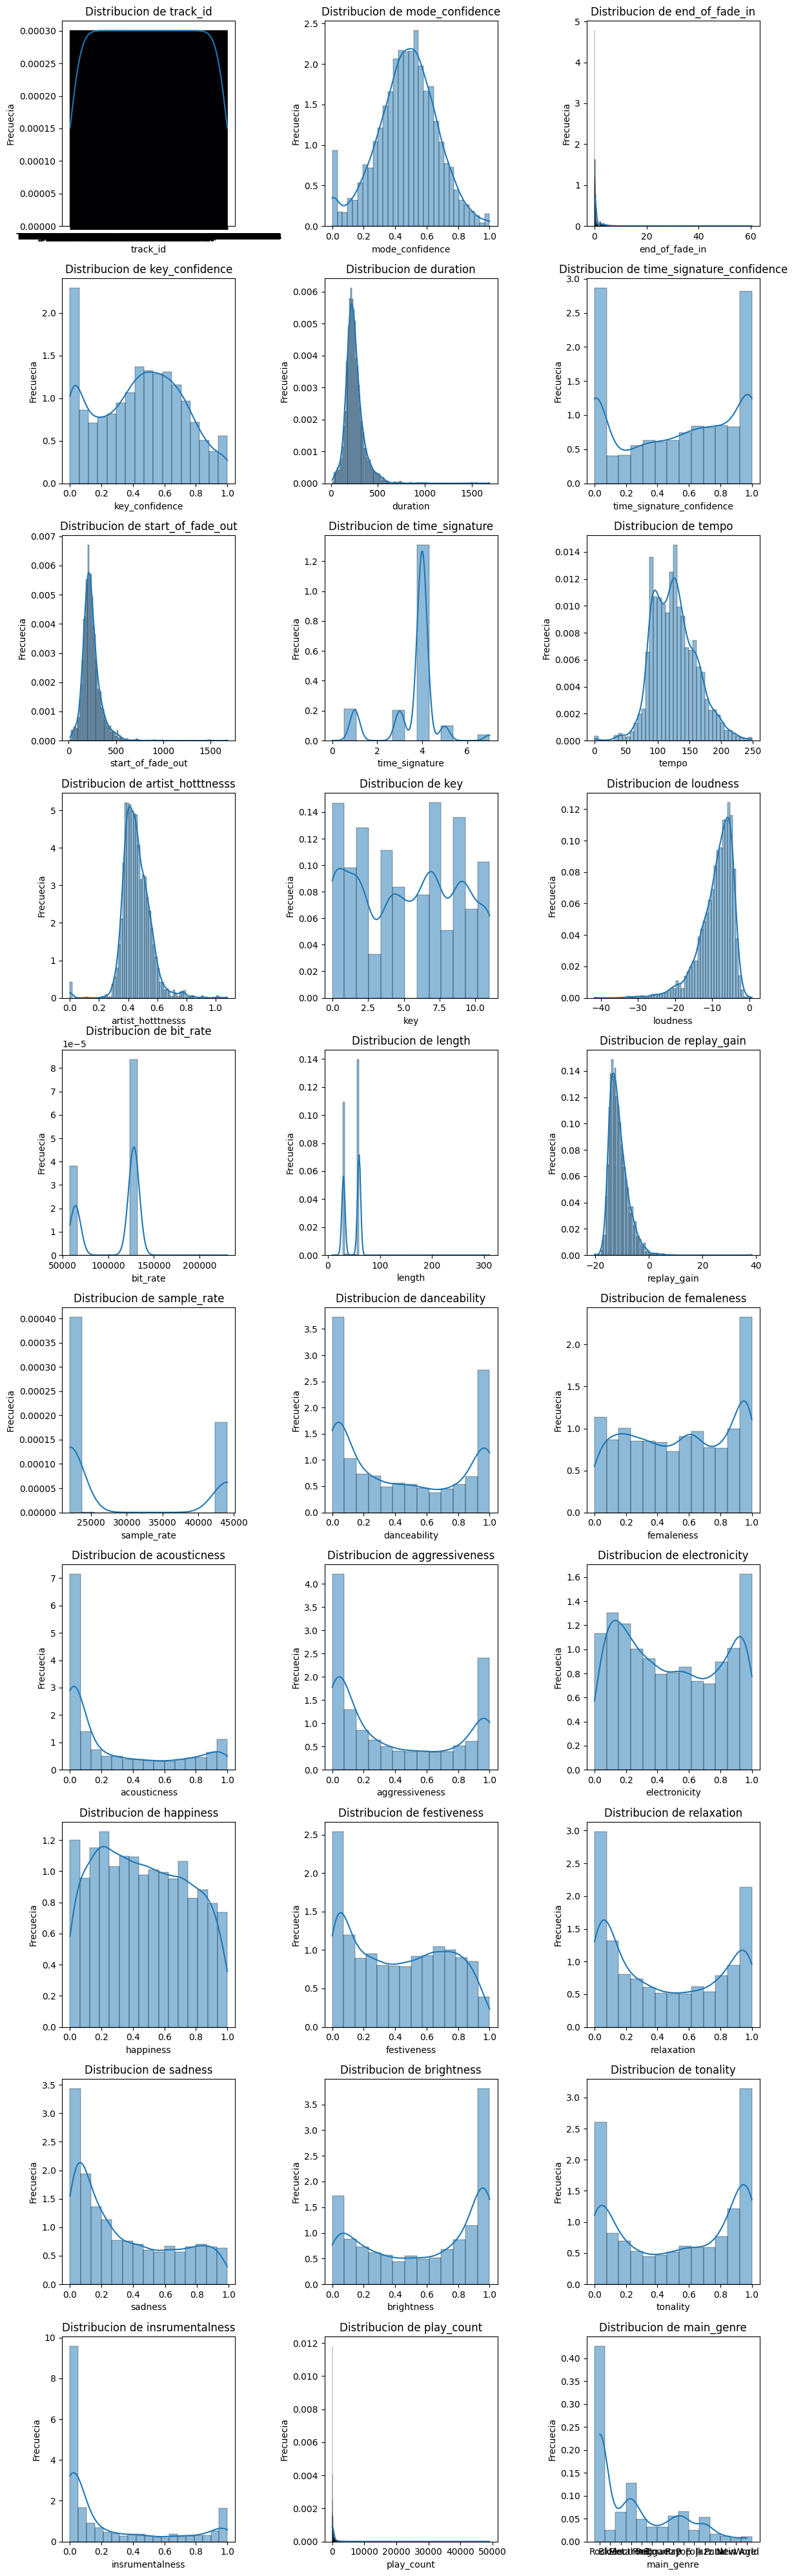

In [241]:
aux  = df_mer.columns
num_var = len(aux)
cols = 3
rows = (num_var // cols) + (num_var % cols)
plt.figure(figsize = (cols*4, rows*4))

for i, v in enumerate(aux, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_mer[v], kde = True, stat = 'density', linewidth = 0.25 )
    plt.plot(linewidth = 2)
    plt.title(f'Distribucion de {v}')
    plt.xlabel(v)
    plt.ylabel('Frecuecia')

plt.tight_layout()
plt.show()
    

OUTLIERS: end_of_fade_in, Duration, start_of_fade_out, loudness, replay_gain

Categoricas: time_signature, Key, bit_rate, length, sample_rate, main_genre


In [242]:
df_mer.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count
count,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3.330000e+03,3.330000e+03,3330.000000,3330.000000,3330.000000,3.330000e+03,3330.000000,3330.000000
mean,0.471971,0.911983,0.439054,250.537805,0.527278,240.870660,3.663363,125.800729,0.456388,5.279880,-8.953480,108075.679580,46.855027,-11.358983,29023.153153,4.416050e-01,5.431135e-01,2.743777e-01,4.008949e-01,0.494576,4.660381e-01,4.225352e-01,0.455529,0.349852,0.589916,5.363020e-01,0.246328,467.716817
std,0.191614,2.205328,0.276908,103.604439,0.371293,101.263597,1.119964,34.270209,0.095505,3.588438,4.577903,29865.628926,15.614642,3.570724,10254.412188,3.834576e-01,3.203668e-01,3.415280e-01,3.808397e-01,0.314047,2.817952e-01,3.019056e-01,0.361275,0.303856,0.361049,3.738967e-01,0.340768,1878.904170
min,0.000000,0.000000,0.000000,14.863220,0.000000,14.863000,0.000000,0.000000,0.000000,0.000000,-41.752000,58145.000000,8.672630,-20.352661,22050.000000,3.000001e-14,7.190201e-11,4.062316e-12,3.000001e-14,0.000013,6.147993e-10,2.580266e-07,0.000736,0.001810,0.000093,3.000001e-14,0.000002,1.000000
1%,0.000000,0.000000,0.000000,56.437095,0.000000,54.930080,1.000000,50.147350,0.286320,0.000000,-24.349580,64028.000000,29.884060,-16.897257,22050.000000,7.899662e-11,4.387197e-03,1.136856e-08,4.724511e-07,0.017470,5.149552e-03,1.316717e-03,0.004189,0.006606,0.002551,1.054249e-07,0.000054,1.000000
25%,0.356250,0.000000,0.204250,192.339142,0.148000,183.131250,4.000000,99.973250,0.396474,2.000000,-11.149500,64058.000000,30.040817,-13.891028,22050.000000,5.275831e-02,2.570719e-01,8.052085e-03,4.297031e-02,0.200964,2.218598e-01,1.287067e-01,0.091735,0.078084,0.223513,1.369093e-01,0.005410,17.000000
50%,0.479000,0.200000,0.455000,235.336690,0.578500,225.010000,4.000000,123.690500,0.447056,5.000000,-7.913000,128056.000000,60.029366,-12.122363,22050.000000,3.522282e-01,5.613017e-01,7.974853e-02,2.535777e-01,0.476828,4.547744e-01,4.126302e-01,0.390139,0.246993,0.688222,5.904834e-01,0.051168,64.000000
75%,0.600000,0.453000,0.648000,290.298325,0.879000,278.027250,4.000000,147.201500,0.509863,9.000000,-5.659000,128111.000000,60.029366,-9.572178,44100.000000,8.640895e-01,8.542334e-01,5.107173e-01,8.175596e-01,0.790406,7.047899e-01,6.879548e-01,0.829054,0.605832,0.947904,9.164003e-01,0.405115,251.750000
99%,0.904130,9.202540,1.000000,559.813818,1.000000,542.902030,7.000000,216.406170,0.768767,11.000000,-2.692060,128111.000000,60.133854,-0.689969,44100.000000,9.999987e-01,9.991403e-01,9.947895e-01,9.999409e-01,0.996431,9.884020e-01,9.658494e-01,0.996411,0.965459,1.000000,9.990849e-01,0.999998,7084.890000
max,1.000000,60.511000,1.000000,1686.569340,1.000000,1677.125000,7.000000,248.441000,1.082503,11.000000,0.709000,230322.000000,310.256317,38.401222,44100.000000,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999930,9.999999e-01,9.999960e-01,0.999999,0.992247,1.000000,9.999726e-01,1.000000,49119.000000


<Axes: >

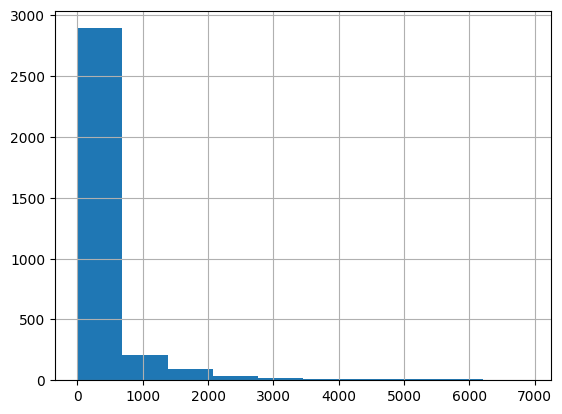

In [243]:
df_mer['play_count'][df_mer['play_count'] < 7000].hist()

In [244]:
len(df_mer[df_mer['play_count'] <= 7085])

3296

In [245]:
df_sin_out = df_mer[(df_mer['end_of_fade_in'] <= 9.202540) & 
                (df_mer['duration'] <= 559.813818) & 
                (df_mer['start_of_fade_out'] <= 542.902030) &
                (df_mer['loudness'] >= -24.349580) &
                (df_mer['replay_gain'] <= -0.689969) &
                (df_mer['play_count'] <= 7085)
                ].copy()

In [246]:
df_sin_out.isnull().sum()

track_id                     0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
duration                     0
time_signature_confidence    0
start_of_fade_out            0
time_signature               0
tempo                        0
artist_hotttnesss            0
key                          0
loudness                     0
bit_rate                     0
length                       0
replay_gain                  0
sample_rate                  0
danceability                 0
femaleness                   0
acousticness                 0
aggressiveness               0
electronicity                0
happiness                    0
festiveness                  0
relaxation                   0
sadness                      0
brightness                   0
tonality                     0
insrumentalness              0
play_count                   0
main_genre                   0
dtype: int64

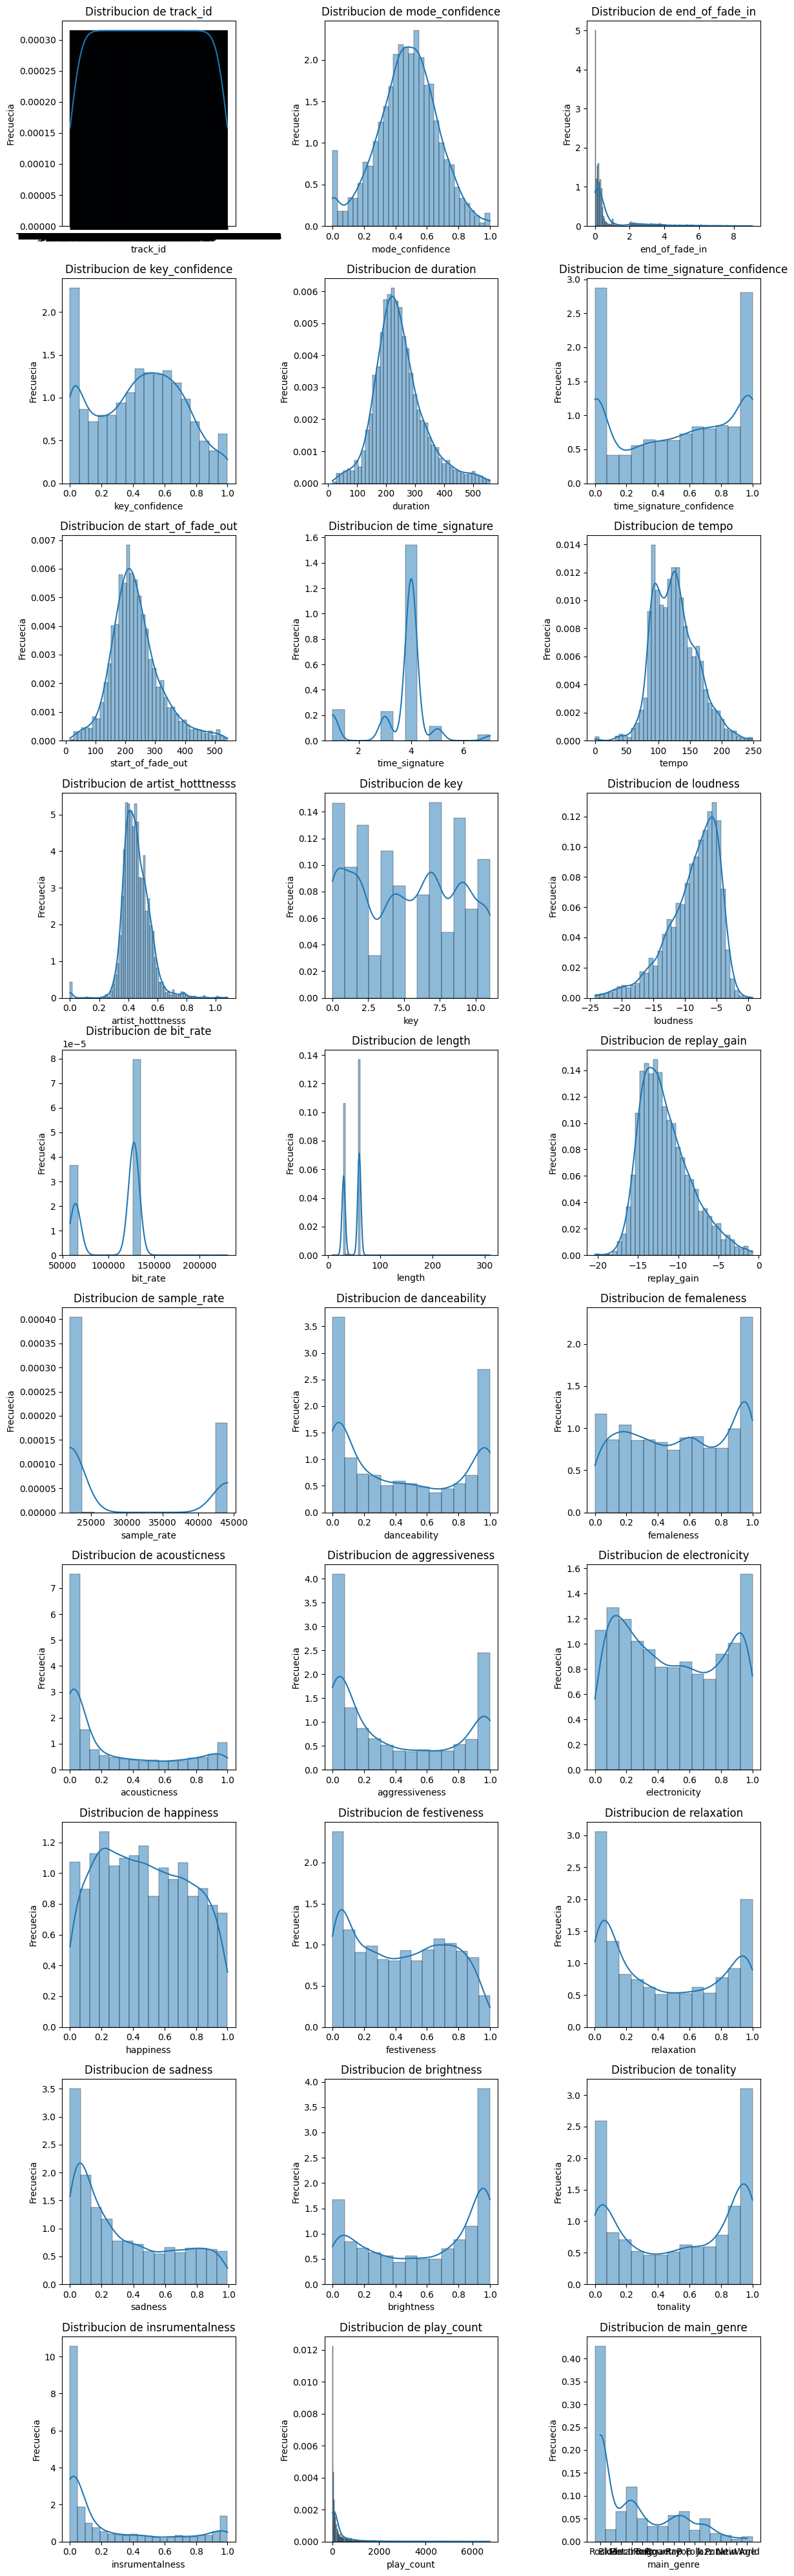

In [247]:
aux  = df_sin_out.columns
num_var = len(aux)
cols = 3
rows = (num_var // cols) + (num_var % cols)
plt.figure(figsize = (cols*4, rows*4))

for i, v in enumerate(aux, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_sin_out[v], kde = True, stat = 'density', linewidth = 0.25 )
    plt.plot(linewidth = 2)
    plt.title(f'Distribucion de {v}')
    plt.xlabel(v)
    plt.ylabel('Frecuecia')

plt.tight_layout()
plt.show()
    

## Ingenieria de Variables

In [248]:
offset = df_sin_out['end_of_fade_in'][df_sin_out['end_of_fade_in'] > 0].min()
df_sin_out['end_of_fade_in_log'] = np.log(df_sin_out['end_of_fade_in']+ (offset))

<Axes: >

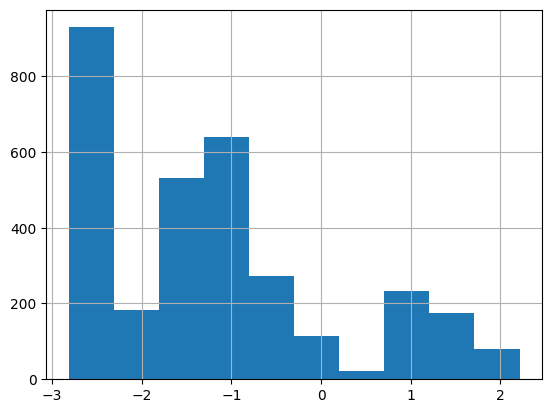

In [249]:
df_sin_out['end_of_fade_in_log'].hist()

In [250]:
df_sin_out.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log
count,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3.176000e+03,3.176000e+03,3.176000e+03,3.176000e+03,3176.000000,3.176000e+03,3176.000000,3176.000000,3176.000000,3176.000000,3.176000e+03,3176.000000,3176.000000,3176.000000
mean,0.472791,0.759667,0.440318,244.862656,0.526399,235.396764,3.670655,126.133194,0.454854,5.278652,-8.670245,108031.027078,46.955447,-11.566592,28965.538413,4.427712e-01,5.396008e-01,2.660915e-01,4.067426e-01,0.493605,4.725545e-01,0.428635,0.444908,0.342458,0.595725,5.358705e-01,0.231258,323.887909,-1.256149
std,0.192046,1.472719,0.277876,85.129869,0.371536,83.145285,1.113341,34.179196,0.094071,3.593274,4.049544,29842.325559,15.642631,3.144911,10231.498927,3.820545e-01,3.217868e-01,3.352635e-01,3.812967e-01,0.311482,2.786591e-01,0.299296,0.358075,0.300408,0.359642,3.731008e-01,0.328146,750.657085,1.370681
min,0.000000,0.000000,0.000000,14.863220,0.000000,14.863000,1.000000,0.000000,0.000000,0.000000,-24.255000,58145.000000,8.672630,-20.352661,22050.000000,3.000001e-14,7.190201e-11,1.838101e-11,3.000001e-14,0.000013,1.420245e-07,0.000010,0.000736,0.001810,0.000217,3.000001e-14,0.000002,1.000000,-2.813411
1%,0.000000,0.000000,0.000000,58.298320,0.000000,55.927500,1.000000,55.649500,0.285846,0.000000,-21.079000,64028.000000,29.884060,-16.892740,22050.000000,1.646581e-10,4.027973e-03,1.300517e-08,6.523432e-07,0.017315,8.586294e-03,0.002315,0.004180,0.006575,0.003240,1.495791e-07,0.000060,1.000000,-2.813411
25%,0.357000,0.000000,0.203750,191.810158,0.146000,182.855500,4.000000,99.997500,0.396096,2.000000,-10.929750,64058.000000,30.040817,-13.927744,22050.000000,5.581679e-02,2.485840e-01,7.653466e-03,4.538730e-02,0.203452,2.304293e-01,0.140117,0.087503,0.076003,0.233815,1.383029e-01,0.005274,16.000000,-2.813411
50%,0.479000,0.199000,0.456500,234.030565,0.576000,224.127500,4.000000,123.745500,0.446520,5.000000,-7.807000,128056.000000,60.029366,-12.190601,22050.000000,3.550267e-01,5.525322e-01,7.653093e-02,2.649044e-01,0.474434,4.608958e-01,0.423164,0.371231,0.238645,0.703863,5.904834e-01,0.046363,63.000000,-1.350927
75%,0.601000,0.432000,0.650250,286.778320,0.879000,275.239250,4.000000,147.843750,0.508813,9.000000,-5.585750,128111.000000,60.029366,-9.733290,44100.000000,8.633986e-01,8.520263e-01,4.853732e-01,8.243564e-01,0.786042,7.084856e-01,0.691886,0.809462,0.591835,0.950028,9.141556e-01,0.366824,237.000000,-0.709277
99%,0.905000,6.957000,1.000000,505.997910,1.000000,493.303500,7.000000,216.605000,0.755781,11.000000,-2.677250,128111.000000,60.133854,-2.862723,44100.000000,9.999973e-01,9.991462e-01,9.928952e-01,9.999433e-01,0.996136,9.855795e-01,0.964998,0.996112,0.964192,1.000000,9.988578e-01,0.999994,4245.250000,1.948336
max,1.000000,9.079000,1.000000,557.896690,1.000000,542.197000,7.000000,248.441000,1.082503,11.000000,0.709000,230322.000000,310.256317,-0.762072,44100.000000,9.999999e-01,9.999861e-01,9.999401e-01,9.999999e-01,0.999709,9.999999e-01,0.999996,0.999999,0.992247,1.000000,9.999726e-01,1.000000,6755.000000,2.212551


<Axes: >

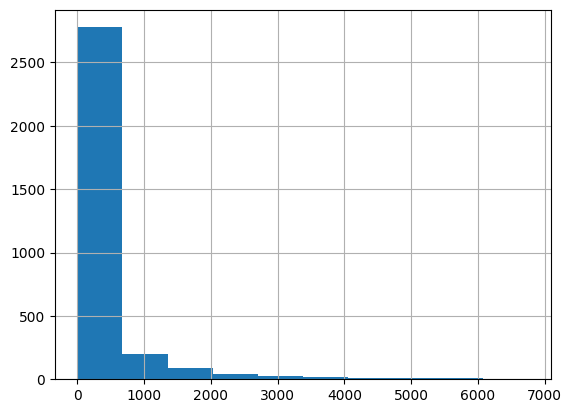

In [251]:
df_sin_out['play_count'].hist()

In [252]:
df_sin_out['play_count'] = pd.cut(df_sin_out['play_count'], bins = [0,450,83256], labels = [0,1] )

In [253]:
len(df_sin_out[df_sin_out['play_count'] == 1])/len(df_sin_out)

0.1709697732997481

<Axes: >

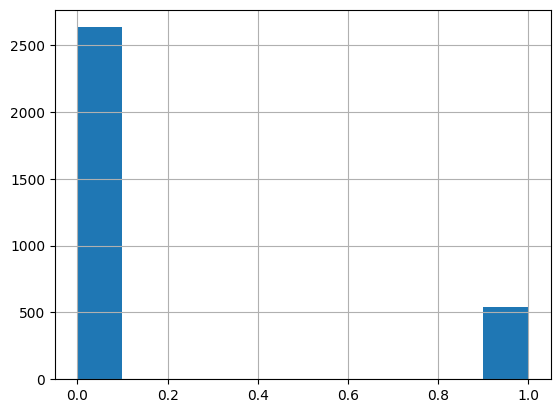

In [254]:
df_sin_out['play_count'].hist()

In [255]:
df_sin_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3176 entries, 0 to 24947
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   track_id                   3176 non-null   object  
 1   mode_confidence            3176 non-null   float64 
 2   end_of_fade_in             3176 non-null   float64 
 3   key_confidence             3176 non-null   float64 
 4   duration                   3176 non-null   float64 
 5   time_signature_confidence  3176 non-null   float64 
 6   start_of_fade_out          3176 non-null   float64 
 7   time_signature             3176 non-null   float64 
 8   tempo                      3176 non-null   float64 
 9   artist_hotttnesss          3176 non-null   float64 
 10  key                        3176 non-null   float64 
 11  loudness                   3176 non-null   float64 
 12  bit_rate                   3176 non-null   float64 
 13  length                     3176 non-n

In [256]:
df_sin_out = pd.get_dummies(df_sin_out, columns = ['main_genre'], prefix = 'Genre')

In [257]:
df_sin_out

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,sample_rate,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,44100.0,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,0,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,22050.0,0.777133,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,0,-2.813411,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,44100.0,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,0,0.488580,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
11,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,22050.0,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,0,-0.495937,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
30,TRAAUEO128E0780CB9,0.523,0.000,0.532,241.52771,0.902,229.837,4.0,108.264,0.586433,10.0,-7.255,64059.0,60.029366,-10.828014,22050.0,0.649937,0.838906,0.000004,0.664901,0.935769,0.297491,0.830720,0.079845,0.068855,0.245584,0.030841,0.021891,1,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,0.376,0.224,0.157,249.12934,0.265,242.196,4.0,141.267,0.396205,4.0,-13.431,128056.0,60.081612,-6.839115,22050.0,1.000000,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348,0.003443,0.016457,0,-1.258781,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
24939,TRZZIJW128F930B20F,0.876,0.000,0.969,58.77506,0.000,58.775,1.0,120.005,0.386984,2.0,-20.022,128057.0,58.801609,-4.788458,22050.0,0.000004,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983,0.998203,0.990937,0,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
24942,TRZZMHR128F1490F28,0.424,4.458,0.307,403.95710,1.000,398.141,4.0,194.020,0.358851,10.0,-11.977,128111.0,30.040817,-7.450308,44100.0,0.768223,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229,0.789736,0.177510,0,1.508069,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
24944,TRZZOUK128F92E3480,0.529,0.000,0.599,213.47220,0.579,208.260,4.0,147.557,0.453524,10.0,-13.685,128111.0,30.040817,-6.247433,44100.0,0.267396,0.760838,0.048918,0.508864,0.788453,0.262665,0.684977,0.189497,0.187421,0.721574,0.874544,0.848592,0,-2.813411,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


Categoricas: time_signature, Key, bit_rate, length, sample_rate, main_genre

In [258]:
df_sin_out['time_signature'].value_counts()

time_signature
4.0    2256
1.0     356
3.0     335
5.0     165
7.0      64
Name: count, dtype: int64

In [259]:
df_sin_out['key'].value_counts()

key
7.0     395
0.0     394
9.0     363
2.0     349
4.0     297
11.0    280
1.0     265
5.0     227
6.0     208
10.0    180
8.0     133
3.0      85
Name: count, dtype: int64

In [260]:
df_sin_out['bit_rate'].value_counts()

bit_rate
128056.0    961
128111.0    929
64028.0     410
64055.0     267
128000.0    245
           ... 
64029.0       1
230322.0      1
64115.0       1
128086.0      1
64118.0       1
Name: count, Length: 74, dtype: int64

In [261]:
df_sin_out['length'].value_counts()

length
60.029366    1197
30.040817     780
60.081612     373
30.040794     311
60.081635     146
             ... 
56.084877       1
31.582018       1
29.805691       1
41.168980       1
58.801609       1
Name: count, Length: 87, dtype: int64

In [262]:
df_sin_out['sample_rate'].value_counts()

sample_rate
22050.0    2179
44100.0     996
24000.0       1
Name: count, dtype: int64

In [263]:
#df_sin_out = pd.get_dummies(df_sin_out, columns = ['key'], prefix = 'key')
df_sin_out = pd.get_dummies(df_sin_out, columns = ['sample_rate'], prefix = 'sample_rate')

In [264]:
df_sin_out.isnull().sum()

track_id                     0
mode_confidence              0
end_of_fade_in               0
key_confidence               0
duration                     0
time_signature_confidence    0
start_of_fade_out            0
time_signature               0
tempo                        0
artist_hotttnesss            0
key                          0
loudness                     0
bit_rate                     0
length                       0
replay_gain                  0
danceability                 0
femaleness                   0
acousticness                 0
aggressiveness               0
electronicity                0
happiness                    0
festiveness                  0
relaxation                   0
sadness                      0
brightness                   0
tonality                     0
insrumentalness              0
play_count                   0
end_of_fade_in_log           0
Genre_Blues                  0
Genre_Country                0
Genre_Electronic             0
Genre_Fo

In [265]:
print(abs(df_sin_out['danceability'][df_sin_out['play_count'] == 1].mean() - df_sin_out['danceability'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['femaleness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['femaleness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['acousticness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['acousticness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['aggressiveness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['aggressiveness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['electronicity'][df_sin_out['play_count'] == 1].mean() - df_sin_out['electronicity'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['happiness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['happiness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['festiveness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['festiveness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['relaxation'][df_sin_out['play_count'] == 1].mean() - df_sin_out['relaxation'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['sadness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['sadness'][df_sin_out['play_count'] == 0].mean()))
print(abs(df_sin_out['brightness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['brightness'][df_sin_out['play_count'] == 0].mean()))


0.027066081094559657
0.017617446454474384
0.004652743292052508
0.004037282098101336
0.011268549054515686
0.012887694635927816
0.010080210519387844
0.020774856092650174
0.003944176461091409
0.04530039562561328


In [266]:
print((df_sin_out['danceability'][df_sin_out['play_count'] == 1].mean() - df_sin_out['danceability'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['femaleness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['femaleness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['acousticness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['acousticness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['aggressiveness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['aggressiveness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['electronicity'][df_sin_out['play_count'] == 1].mean() - df_sin_out['electronicity'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['happiness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['happiness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['festiveness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['festiveness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['relaxation'][df_sin_out['play_count'] == 1].mean() - df_sin_out['relaxation'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['sadness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['sadness'][df_sin_out['play_count'] == 0].mean()))
print((df_sin_out['brightness'][df_sin_out['play_count'] == 1].mean() - df_sin_out['brightness'][df_sin_out['play_count'] == 0].mean()))

0.027066081094559657
-0.017617446454474384
-0.004652743292052508
0.004037282098101336
-0.011268549054515686
0.012887694635927816
0.010080210519387844
-0.020774856092650174
0.003944176461091409
0.04530039562561328


In [267]:
df_sin_out['danceability'][df_sin_out['play_count'] == 1].mean()

np.float64(0.4652097518029359)

In [268]:
df_sin_out['brightness'][df_sin_out['play_count'] == 1].mean()

np.float64(0.6332808088774371)

In [269]:
df_sin_out['aggressiveness'][df_sin_out['play_count'] == 1].mean()

np.float64(0.4100896080562686)

In [270]:
lst_feat = ['danceability', 'femaleness','acousticness','aggressiveness','electronicity','happiness','festiveness','relaxation','sadness',
           'brightness']

In [271]:
df_sin_out[lst_feat]

,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness
0,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842
7,0.777133,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236
8,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689
11,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223
30,0.649937,0.838906,0.000004,0.664901,0.935769,0.297491,0.830720,0.079845,0.068855,0.245584
...,...,...,...,...,...,...,...,...,...,...
24929,1.000000,0.591204,0.039558,0.050024,0.966702,0.980899,0.937699,0.790729,0.214783,0.128348
24939,0.000004,0.652726,0.508678,0.012076,0.241765,0.224602,0.000784,0.775100,0.840745,0.155983
24942,0.768223,0.719714,0.038381,0.784127,0.953748,0.017005,0.654384,0.415814,0.082515,0.886229
24944,0.267396,0.760838,0.048918,0.508864,0.788453,0.262665,0.684977,0.189497,0.187421,0.721574


In [272]:
df_sin_out[lst_feat][df_sin_out['play_count'] == 0].idxmax(axis = 1).value_counts()

brightness        636
aggressiveness    543
danceability      446
femaleness        332
relaxation        276
electronicity     153
happiness         128
acousticness       77
festiveness        21
sadness            21
Name: count, dtype: int64

In [273]:
df_sin_out[lst_feat][df_sin_out['play_count'] == 1].idxmax(axis = 1).value_counts()

brightness        142
danceability      113
aggressiveness     97
femaleness         62
relaxation         57
electronicity      21
happiness          20
acousticness       19
festiveness         7
sadness             5
Name: count, dtype: int64

In [274]:
df_sin_out['brightness*danceability'] = df_sin_out['danceability'] * df_sin_out['brightness']

In [275]:
mean = df_sin_out[lst_feat].mean(axis = 1).mean()

In [276]:
df_sin_out['aggressiveness'].mean()

np.float64(0.40674257916322687)

In [277]:
mean

np.float64(0.44330910562897996)

In [278]:
df_sin_out['danceability_upper_mean'] = df_sin_out['danceability'].apply(lambda x: x > mean)

In [279]:
df_sin_out['brightness_upper_mean'] = df_sin_out['brightness'].apply(lambda x: x > df_sin_out['brightness'].mean())

In [280]:
df_sin_out['aggressiveness_upper_mean'] = df_sin_out['aggressiveness'].apply(lambda x: x > df_sin_out['aggressiveness'].mean())

In [281]:
df_sin_out['key_confidence*key'] = df_sin_out['key_confidence'] * df_sin_out['key']

<Axes: >

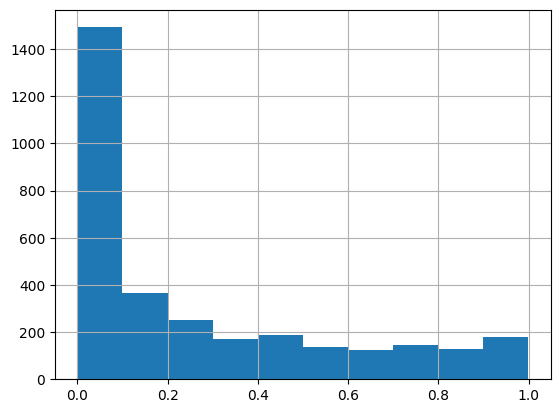

In [282]:
df_sin_out['brightness*danceability'].hist()

<Axes: >

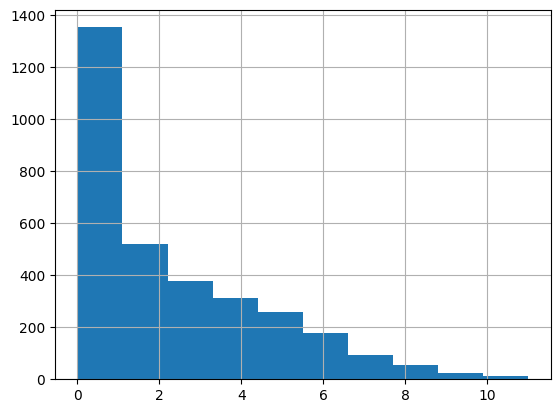

In [283]:
df_sin_out['key_confidence*key'].hist()

In [284]:
df_sin_out['key_confidence*key'][df_sin_out['key_confidence*key'] <= 0]

8        0.0
11       0.0
104      0.0
115      0.0
118      0.0
        ... 
24692    0.0
24704    0.0
24730    0.0
24870    0.0
24873    0.0
Name: key_confidence*key, Length: 547, dtype: float64

In [285]:
df_sin_out['brightness*danceability_log'] = np.log(df_sin_out['brightness*danceability'])

<Axes: >

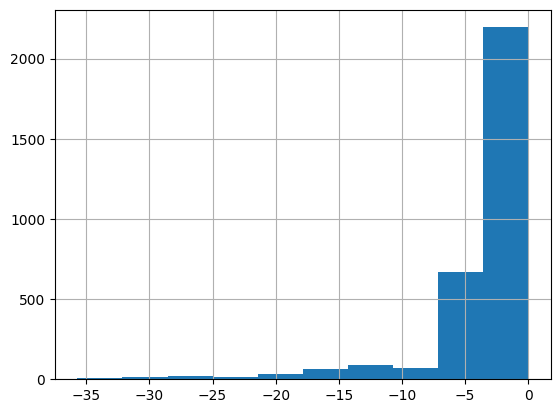

In [286]:
df_sin_out['brightness*danceability_log'].hist()

In [287]:
df_sin_out['time_signature*time_signature_confidence'] = df_sin_out['time_signature'] * df_sin_out['time_signature_confidence']

In [288]:
df_sin_out['loudness'][df_sin_out['play_count'] == 1].mean()

np.float64(-7.9839834254143645)

In [289]:
df_sin_out['loudness'][df_sin_out['play_count'] == 0].mean()

np.float64(-8.81177136346373)

In [290]:
df_sin_out['loudness'].mean()

np.float64(-8.670244647355164)

In [291]:
df_sin_out['loudness_upper_mean'] = df_sin_out['loudness'].apply(lambda x: x > df_sin_out['loudness'].mean())

In [292]:
df_sin_out['danceability*loudness'] = df_sin_out['danceability'] * df_sin_out['loudness']

In [293]:
for var in lst_feat:
    if var != 'danceability':
        df_sin_out[f'danceability_{var}_ratio'] = df_sin_out['danceability'] / df_sin_out[var]

In [294]:
df_sin_out

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,0,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,3.146440e-01,False,True,False,7.000,-1.156313,3.024,True,-2.751093,13.155891,0.356250,12.592624,11.621068,0.580771,3.887530,1.215225,0.510344,0.327056
7,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,0.777133,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,0,-2.813411,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,5.037659e-01,True,True,True,3.280,-0.685644,1.696,True,-5.027276,48.959344,6.067335,1.362856,1.570909,2.349052,1.046616,2.259622,4.430044,1.198843
8,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,0,0.488580,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,1.127860e-03,False,False,True,0.000,-6.787433,2.400,True,-0.013322,0.009214,0.352330,0.002644,0.006720,0.007599,0.003162,0.787836,0.087002,0.006195
11,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,0,-0.495937,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,1.216320e-01,False,True,True,0.000,-2.106756,2.760,True,-0.593465,1.524226,12.865774,0.139488,0.476939,0.130416,0.219628,1.526957,1.246265,0.123050
30,TRAAUEO128E0780CB9,0.523,0.000,0.532,241.52771,0.902,229.837,4.0,108.264,0.586433,10.0,-7.255,64059.0,60.029366,-10.828014,0.649937,0.838906,0.000004,0.664901,0.935769,0.297491,0.830720,0.079845,0.068855,0.245584,0.030841,0.021891,1,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,1.596139e-01,True,False,True,5.320,-1.834998,3.608,True,-4.715294,0.774744,150407.745964,0.977495,0.694549,2.184730,0.782379,8.139943,9.439203,2.646501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,TRZYZUO128F92E8451,0.376,0.224,0.157,249.12934,0.265,242.196,4.0,141.267,0.396205,4.0,-13.431,128056.0,60.081612,-6.839115,

In [295]:
lyrics  = pd.read_csv('datos/song_lyrics.csv')

In [296]:
lyrics

,track_id,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
0,TRSZDWT128F4282FF8,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRFVRRO128F426294C,2.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,5.0,0.0,15.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,5.0,4.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,9.0,3.0,1.0,0.0,0.0,8.0,0.0
2,TRRCNRA128F9348098,1.0,1.0,0.0,1.0,5.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,8.0,14.0,5.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,16.0,4.0
3,TRMWJFM128F4235893,4.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,7.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,16.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.0,0.0,8.0,0.0,0.0,0.0,2.0,6.0,1.0,1.0,2.0,2.0,0.0,0.0,11.0,18.0
4,TRBMXWS12903CDEC1A,4.0,2.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,2.0,6.0,2.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,1.0,1.0,0.0,2.0,0.0,9.0,3.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6798,TRATWKM128F147BCB2,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
6799,TRXFLKP128F92F6724,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,6.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,30.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,15.0,4.0
6800,TRATCOK128F423CEF4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [297]:
pd.set_option('display.max_rows', None)
df_sin_out.isnull().sum()

track_id                                    0
mode_confidence                             0
end_of_fade_in                              0
key_confidence                              0
duration                                    0
time_signature_confidence                   0
start_of_fade_out                           0
time_signature                              0
tempo                                       0
artist_hotttnesss                           0
key                                         0
loudness                                    0
bit_rate                                    0
length                                      0
replay_gain                                 0
danceability                                0
femaleness                                  0
acousticness                                0
aggressiveness                              0
electronicity                               0
happiness                                   0
festiveness                       

In [298]:
pd.reset_option('display.max_rows')

In [299]:
df_lyr = pd.merge(df_sin_out, lyrics, on = 'track_id', how = 'outer')

In [300]:
df_lyr

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,0,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.314644,False,True,False,7.000,-1.156313,3.024,True,-2.751093,13.155891,0.356250,12.592624,11.621068,0.580771,3.887530,1.215225,0.510344,0.327056,6.0,6.0,2.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,3.0,5.0,7.0,4.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,6.0,0.0,3.0,2.0,0.0,2.0,0.0,1.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0
1,TRAADKZ128F149BDFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,3.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,1.0,5.0,0.0
2,TRAAEHK128F92C9C79,0.360,0.000,0.328,212.74077,0.424,204.516,4.0,166.349,0.000000,10.0,-6.469,128056.0,60.029366,-13.997978,0.777133,0.015873,0.128085,0.570224,0.494703,0.330829,0.742520,0.343922,0.175423,0.648236,0.487262,0.097224,0,-2.813411,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0.503766,True,True,True,3.280,-0.685644,1.696,True,-5.027276,48.959344,6.067335,1.362856,1.570909,2.349052,1.046616,2.259622,4.430044,1.198843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [301]:
pd.set_option('display.max_rows', None)
df_lyr.isnull().sum()

track_id                                       0
mode_confidence                             5118
end_of_fade_in                              5118
key_confidence                              5118
duration                                    5118
time_signature_confidence                   5118
start_of_fade_out                           5118
time_signature                              5118
tempo                                       5118
artist_hotttnesss                           5118
key                                         5118
loudness                                    5118
bit_rate                                    5118
length                                      5118
replay_gain                                 5118
danceability                                5118
femaleness                                  5118
acousticness                                5118
aggressiveness                              5118
electronicity                               5118
happiness           

In [302]:
pd.reset_option('display.max_rows')


In [303]:
df_lyr = df_lyr.dropna()

In [304]:
pd.set_option('display.max_rows', None)
df_lyr.isnull().sum()

track_id                                    0
mode_confidence                             0
end_of_fade_in                              0
key_confidence                              0
duration                                    0
time_signature_confidence                   0
start_of_fade_out                           0
time_signature                              0
tempo                                       0
artist_hotttnesss                           0
key                                         0
loudness                                    0
bit_rate                                    0
length                                      0
replay_gain                                 0
danceability                                0
femaleness                                  0
acousticness                                0
aggressiveness                              0
electronicity                               0
happiness                                   0
festiveness                       

In [305]:
df_lyr.dtypes

track_id                                      object
mode_confidence                              float64
end_of_fade_in                               float64
key_confidence                               float64
duration                                     float64
time_signature_confidence                    float64
start_of_fade_out                            float64
time_signature                               float64
tempo                                        float64
artist_hotttnesss                            float64
key                                          float64
loudness                                     float64
bit_rate                                     float64
length                                       float64
replay_gain                                  float64
danceability                                 float64
femaleness                                   float64
acousticness                                 float64
aggressiveness                               f

In [306]:
pd.reset_option('display.max_rows')

In [307]:
df_lyr

,track_id,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
0,TRAABLR128F423B7E3,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,0,-2.813411,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.314644,False,True,False,7.000,-1.156313,3.024,True,-2.751093,13.155891,0.356250,12.592624,11.621068,0.580771,3.887530,1.215225,0.510344,0.327056,6.0,6.0,2.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,3.0,5.0,7.0,4.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,6.0,0.0,3.0,2.0,0.0,2.0,0.0,1.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0
3,TRAAFOH128E078BD7E,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,0,0.488580,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,0.001128,False,False,True,0.000,-6.787433,2.400,True,-0.013322,0.009214,0.352330,0.002644,0.006720,0.007599,0.003162,0.787836,0.087002,0.006195,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
6,TRAAIMO128F92EB778,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,0,-0.495937,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.121632,False,True,True,0.000,-2.106756,2.760,True,-0.593465,1.524226,12.865774,0.139488,0.476939,0.130416,0.219628,1.526957,1.246265,0.123050,5.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,3.0,0.0,4.0,4.0,0.0,2.0,0.0,5

In [308]:
df_lyr = df_lyr.drop(columns = ['track_id'])

In [309]:
lst_obj = df_lyr.select_dtypes(include = 'object').columns

In [310]:
lst_obj

Index(['Genre_Blues', 'Genre_Country', 'Genre_Electronic', 'Genre_Folk',
       'Genre_Jazz', 'Genre_Latin', 'Genre_Metal', 'Genre_New Age',
       'Genre_Pop', 'Genre_Punk', 'Genre_Rap', 'Genre_Reggae', 'Genre_RnB',
       'Genre_Rock', 'Genre_World', 'sample_rate_22050.0',
       'sample_rate_24000.0', 'sample_rate_44100.0', 'danceability_upper_mean',
       'brightness_upper_mean', 'aggressiveness_upper_mean',
       'loudness_upper_mean'],
      dtype='object')

In [311]:
df_modelo = df_lyr.copy()
df_modelo[lst_obj] = df_lyr[lst_obj].astype(int)

In [312]:
df_modelo

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,play_count,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
0,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,0,-2.813411,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.314644,0,1,0,7.000,-1.156313,3.024,1,-2.751093,13.155891,0.356250,12.592624,11.621068,0.580771,3.887530,1.215225,0.510344,0.327056,6.0,6.0,2.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,3.0,5.0,7.0,4.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,6.0,0.0,3.0,2.0,0.0,2.0,0.0,1.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0
3,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,0,0.488580,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.001128,0,0,1,0.000,-6.787433,2.400,1,-0.013322,0.009214,0.352330,0.002644,0.006720,0.007599,0.003162,0.787836,0.087002,0.006195,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
6,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,0,-0.495937,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.121632,0,1,1,0.000,-2.106756,2.760,1,-0.593465,1.524226,12.865774,0.139488,0.476939,0.130416,0.219628,1.526957,1.246265,0.123050,5.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,3.0,0.0,4.0,4.0,0.0,2.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,7.0,0.0,2.0,1.0,12.0,0.0,3.0,8.0,0.0,3.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,0.0,0.0,14.0,3.0
10,0.523,0.000,0.532,241.52771,0.902,229.837,4.0,108.264,0.586433,10.0,-7.255,64059.0,60.029366,

In [313]:
df_modelo['play_count'].value_counts()

play_count
0    1327
1     358
Name: count, dtype: int64

## Modelos

In [314]:
X = df_modelo.drop(columns = ['play_count'])

In [315]:
y = df_modelo['play_count']

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 40)

In [317]:
selec_R = SelectKBest(score_func = f_classif, k = 30)
X_train_s = selec_R.fit_transform(X_train, y_train)
X_test_s = selec_R.transform(X_test)

In [318]:
Ran_For = RandomForestClassifier()
Ran_For.fit(X_train_s,y_train)

RandomForestClassifier()

In [319]:
cv_Ran_F = cross_val_score(Ran_For,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [320]:
print(cv_Ran_F)
print("ROC: %0.2f (+/- %0.2f)" % (cv_Ran_F.mean(), cv_Ran_F.std() * 2))

[0.74255157 0.73725806 0.74       0.70983871 0.80118499]
ROC: 0.75 (+/- 0.06)


In [321]:
y_pred = Ran_For.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5224747474747475


In [322]:
XGB = XGBClassifier()

In [323]:
XGB.fit(X_train_s, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [324]:
cv_XGB = cross_val_score(XGB,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [325]:
print(cv_XGB)
print("ROC: %0.2f (+/- %0.2f)" % (cv_XGB.mean(), cv_XGB.std() * 2))

[0.69169486 0.71483871 0.70795699 0.68731183 0.7919684 ]
ROC: 0.72 (+/- 0.08)


In [326]:
y_pred = XGB.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5530303030303031


In [327]:
best_f = selec_R.get_support()

In [328]:
X.columns[best_f]

Index(['artist_hotttnesss', 'length', 'acousticness', 'aggressiveness',
       'happiness', 'sadness', 'brightness', 'tonality', 'Genre_Metal',
       'sample_rate_22050.0', 'sample_rate_44100.0', 'brightness*danceability',
       'danceability_upper_mean', 'aggressiveness_upper_mean',
       'brightness*danceability_log', 'but', 'come', 'feel', 'go', 'here', 'i',
       'on', 'say', 'so', 'think', 'to', 'when', 'where', 'you', 'your'],
      dtype='object')

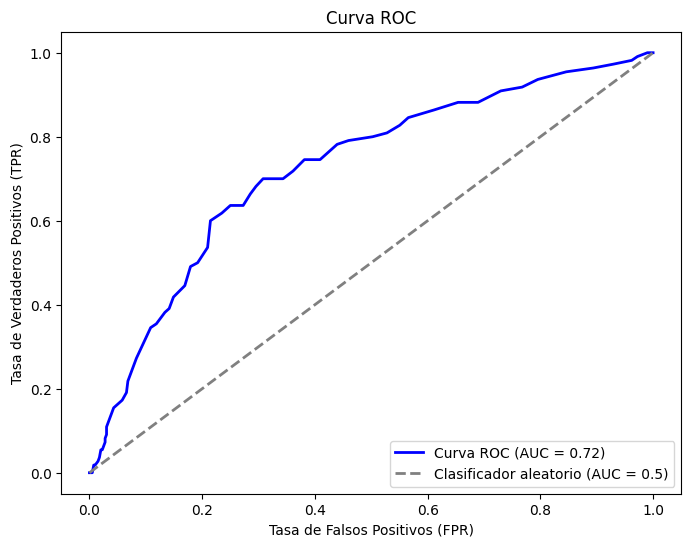

In [329]:
y_score = Ran_For.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [330]:
Rf_param = {
    
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}


In [331]:
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=Rf_param,
    n_iter=100,  
    cv=5, 
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1  
)


In [332]:
rf_random_search.fit(X_train_s, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [None, 5, 10, 15, 20, 25],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76bd8ff5edb0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76bd8ff5de80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76bd9517db80>},
                   random_state=42, scoring='accuracy')

In [333]:
rf_random_search.best_score_

np.float64(0.7939091236927516)

In [334]:
y_pred = rf_random_search.best_estimator_.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5260101010101009


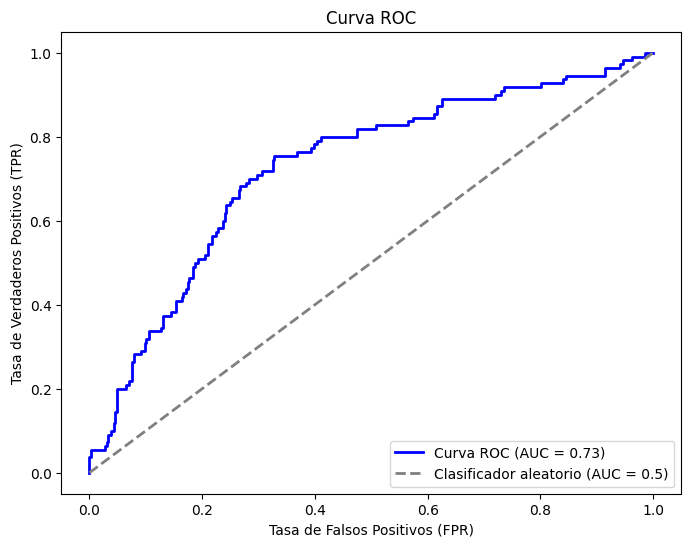

In [335]:
y_score = rf_random_search.best_estimator_.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [336]:
X

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
0,0.829,0.000,1.000,491.12771,0.756,486.034,4.0,119.826,0.447935,7.0,-8.576,128100.0,33.306122,-15.267794,0.320790,0.024384,0.900463,0.025474,0.027604,0.552351,0.082518,0.263976,0.628576,0.980842,0.995515,0.001275,-2.813411,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.314644,0,1,0,7.000,-1.156313,3.024,1,-2.751093,13.155891,0.356250,12.592624,11.621068,0.580771,3.887530,1.215225,0.510344,0.327056,6.0,6.0,2.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,3.0,5.0,7.0,4.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,6.0,0.0,3.0,2.0,0.0,2.0,0.0,1.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0
3,0.472,1.570,0.365,221.98812,0.600,208.747,4.0,210.102,0.417325,0.0,-5.040,128111.0,30.040817,-13.311316,0.002643,0.286867,0.007502,0.999753,0.393359,0.347861,0.835842,0.003355,0.030382,0.426689,0.611897,0.001252,0.488580,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.001128,0,0,1,0.000,-6.787433,2.400,1,-0.013322,0.009214,0.352330,0.002644,0.006720,0.007599,0.003162,0.787836,0.087002,0.006195,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
6,0.554,0.549,0.460,209.34485,0.690,199.343,4.0,109.003,0.427150,0.0,-4.851,128111.0,30.040794,-14.724085,0.122339,0.080263,0.009509,0.877056,0.256508,0.938064,0.557026,0.080119,0.098164,0.994223,0.861095,0.023406,-0.495937,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.121632,0,1,1,0.000,-2.106756,2.760,1,-0.593465,1.524226,12.865774,0.139488,0.476939,0.130416,0.219628,1.526957,1.246265,0.123050,5.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,3.0,0.0,4.0,4.0,0.0,2.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,7.0,0.0,2.0,1.0,12.0,0.0,3.0,8.0,0.0,3.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,0.0,0.0,14.0,3.0
10,0.523,0.000,0.532,241.52771,0.902,229.837,4.0,108.264,0.586433,10.0,-7.255,64059.0,60.029366,-10.828014,0.6499

In [337]:
scaler = StandardScaler()

In [338]:
lst_float = df_modelo.select_dtypes(include = ['float64']).columns

In [339]:
X[lst_float] = scaler.fit_transform(X[lst_float])

In [340]:
X.describe()

,mode_confidence,end_of_fade_in,key_confidence,duration,time_signature_confidence,start_of_fade_out,time_signature,tempo,artist_hotttnesss,key,loudness,bit_rate,length,replay_gain,danceability,femaleness,acousticness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness,end_of_fade_in_log,Genre_Blues,Genre_Country,Genre_Electronic,Genre_Folk,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_New Age,Genre_Pop,Genre_Punk,Genre_Rap,Genre_Reggae,Genre_RnB,Genre_Rock,Genre_World,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness*danceability,danceability_upper_mean,brightness_upper_mean,aggressiveness_upper_mean,key_confidence*key,brightness*danceability_log,time_signature*time_signature_confidence,loudness_upper_mean,danceability*loudness,danceability_femaleness_ratio,danceability_acousticness_ratio,danceability_aggressiveness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,danceability_festiveness_ratio,danceability_relaxation_ratio,danceability_sadness_ratio,danceability_brightness_ratio,a,all,am,and,are,as,at,away,babi,back,be,been,but,by,ca,can,caus,come,could,day,de,do,down,feel,for,from,get,give,go,gonna,got,have,he,heart,her,here,how,i,if,in,is,it,just,know,la,let,life,like,look,love,make,man,me,more,my,need,never,night,no,not,now,of,oh,on,one,our,out,que,right,say,see,she,so,take,tell,that,the,there,they,thing,think,this,time,to,up,want,was,way,we,what,when,where,who,will,with,would,y,yeah,you,your
count,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1.685000e+03,1685.000000,1685.000000,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03
mean,6.746993e-17,4.638558e-17,1.075302e-16,3.152111e-16,-6.009041e-17,4.743980e-18,8.433742e-17,1.781628e-16,1.802712e-16,2.530123e-17,-1.033133e-16,1.475905e-16,0.000000,-5.545185e-16,1.096386e-16,-6.009041e-17,1.686748e-17,-2.108435e-17,-5.798197e-17,1.222893e-16,5.481932e-17,-3.373497e-17,-9.277116e-17,-2.045182e-16,-1.433736e-16,6.325306e-18,1.349399e-16,0.013056,0.039763,0.043917,0.0

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 30)

In [342]:
selec_Rl = SelectKBest(score_func = f_classif, k = 30)
X_train_s = selec_Rl.fit_transform(X_train, y_train)
X_test_s = selec_Rl.transform(X_test)

In [343]:
Log_Reg = LogisticRegression()

In [344]:
Log_Reg.fit(X_train_s, y_train)

LogisticRegression()

In [345]:
cv_log_r = cross_val_score(Log_Reg,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [346]:
print(cv_log_r)
print("ROC: %0.2f (+/- %0.2f)" % (cv_log_r.mean(), cv_log_r.std() * 2))

[0.77085321 0.72040276 0.7281399  0.69827957 0.76475676]
ROC: 0.74 (+/- 0.05)


In [347]:
y_pred = Log_Reg.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5577128607053794


In [348]:
LDA = LinearDiscriminantAnalysis()

In [349]:
LDA.fit(X_train_s, y_train)

LinearDiscriminantAnalysis()

In [350]:
cv_LDA = cross_val_score(LDA,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [351]:
print(cv_LDA)
print("ROC: %0.2f (+/- %0.2f)" % (cv_LDA.mean(), cv_LDA.std() * 2))

[0.77413884 0.72824589 0.73407525 0.68956989 0.76356757]
ROC: 0.74 (+/- 0.06)


In [352]:
y_pred = LDA.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5612278826742666


In [353]:
Nv_Bayesian = GaussianNB()

In [354]:
Nv_Bayesian.fit(X_train_s, y_train)

GaussianNB()

In [355]:
cv_Nv = cross_val_score(Nv_Bayesian,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [356]:
print(cv_Nv)
print("ROC: %0.2f (+/- %0.2f)" % (cv_Nv.mean(), cv_Nv.std() * 2))

[0.64599894 0.70779014 0.67689454 0.63069892 0.6892973 ]
ROC: 0.67 (+/- 0.06)


In [357]:
y_pred = Nv_Bayesian.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5040850255314095


In [358]:
svc = SVC()

In [359]:
svc.fit(X_train_s, y_train)

SVC()

In [360]:
cv_svc = cross_val_score(svc,X_train_s, y_train, cv = 5, scoring = 'roc_auc')

In [361]:
print(cv_svc)
print("ROC: %0.2f (+/- %0.2f)" % (cv_svc.mean(), cv_svc.std() * 2))

[0.76873344 0.76767356 0.68712242 0.66462366 0.75037838]
ROC: 0.73 (+/- 0.09)


In [362]:
y_pred = svc.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.5035150219688873


In [363]:
logistic_param = {
    
    'penalty': ['l1', 'l2'],
    'C': uniform(0.001, 10),  
    'solver': ['liblinear', 'saga'],
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}


In [364]:
logistic_random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=logistic_param,
    n_iter=100,  
    cv=5,  
    scoring='roc_auc',  
    random_state=42,
    n_jobs=-1 
)

In [365]:
logistic_random_search.fit(X_train_s, y_train)

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x76bd90551400>,
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [100, 500, 1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='roc_auc')

In [366]:
logistic_random_search.best_score_

np.float64(0.7520039318255637)

In [367]:
logistic_random_search.best_params_

{'C': np.float64(0.517817211686077),
 'class_weight': 'balanced',
 'max_iter': 500,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.01}

In [368]:
y_pred = logistic_random_search.best_estimator_.predict(X_test_s)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Scoring con datos no vistos: {roc_auc}")

Scoring con datos no vistos: 0.701389383683648


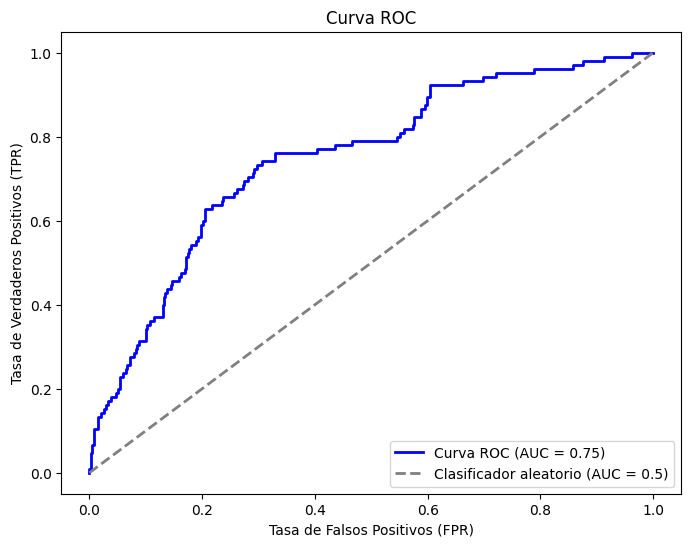

In [369]:
y_score = logistic_random_search.best_estimator_.predict_proba(X_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       401
           1       0.40      0.66      0.50       105

    accuracy                           0.73       506
   macro avg       0.65      0.70      0.66       506
weighted avg       0.79      0.73      0.75       506



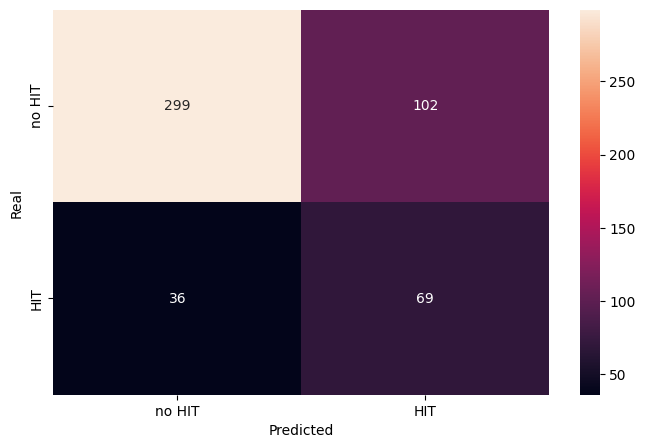

In [370]:
def metrics(real, predicted):
    print(classification_report(real, predicted))

    confusion_mat = confusion_matrix(real, predicted)
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=['no HIT', 'HIT'], yticklabels=['no HIT', 'HIT'])
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

metrics(y_test, y_pred)

In [371]:
print(logistic_random_search.best_estimator_.coef_[0])
print(logistic_random_search.best_estimator_.intercept_[0])

[ 1.03375376 -0.13491934  0.          0.08836667 -0.09578022  0.05076451
  0.2081656   0.09217999  1.11974824 -1.79477069  1.19665585 -0.25139898
 -0.28812474  0.          0.         -0.21398104 -0.14655565 -0.16456594
  0.09159669  0.08586978  0.07165411 -0.24467281  0.02908753  0.0160977
  0.10157479  0.03339855  0.02217005  0.17794213  0.01175643  0.0233209 ]
-0.07870361872358947


In [372]:
lst_Best = X.columns[selec_Rl.get_support(indices=True)]

In [373]:
lst_Best

Index(['artist_hotttnesss', 'length', 'acousticness', 'aggressiveness',
       'festiveness', 'sadness', 'brightness', 'insrumentalness',
       'Genre_Electronic', 'Genre_Jazz', 'Genre_Latin', 'Genre_Metal',
       'Genre_Rap', 'sample_rate_22050.0', 'sample_rate_24000.0',
       'sample_rate_44100.0', 'brightness_upper_mean',
       'aggressiveness_upper_mean', 'danceability_femaleness_ratio',
       'danceability_electronicity_ratio', 'danceability_happiness_ratio',
       'at', 'babi', 'can', 'come', 'here', 'i', 'say', 'so', 'we'],
      dtype='object')

In [374]:
df_best = pd.DataFrame({
    'Variable': lst_Best,
    'Coeficiente': logistic_random_search.best_estimator_.coef_[0]
}).sort_values(by = 'Coeficiente', ascending = False)

In [375]:
df_best

,Variable,Coeficiente
10,Genre_Latin,1.196656
8,Genre_Electronic,1.119748
0,artist_hotttnesss,1.033754
6,brightness,0.208166
27,say,0.177942
24,come,0.101575
7,insrumentalness,0.092180
18,danceability_femaleness_ratio,0.091597
3,aggressiveness,0.088367
19,danceability_electronicity_ratio,0.085870


In [394]:
with open ('Modelo_Examen_2.pkl', 'wb') as file:
    pck.dump(logistic_random_search.best_estimator_, file)

In [376]:
X[lst_Best].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 8290
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   artist_hotttnesss                 1685 non-null   float64
 1   length                            1685 non-null   float64
 2   acousticness                      1685 non-null   float64
 3   aggressiveness                    1685 non-null   float64
 4   festiveness                       1685 non-null   float64
 5   sadness                           1685 non-null   float64
 6   brightness                        1685 non-null   float64
 7   insrumentalness                   1685 non-null   float64
 8   Genre_Electronic                  1685 non-null   int64  
 9   Genre_Jazz                        1685 non-null   int64  
 10  Genre_Latin                       1685 non-null   int64  
 11  Genre_Metal                       1685 non-null   int64  
 12  Genre_Rap  

In [377]:
df_modelo[lst_Best]

,artist_hotttnesss,length,acousticness,aggressiveness,festiveness,sadness,brightness,insrumentalness,Genre_Electronic,Genre_Jazz,Genre_Latin,Genre_Metal,Genre_Rap,sample_rate_22050.0,sample_rate_24000.0,sample_rate_44100.0,brightness_upper_mean,aggressiveness_upper_mean,danceability_femaleness_ratio,danceability_electronicity_ratio,danceability_happiness_ratio,at,babi,can,come,here,i,say,so,we
0,0.447935,33.306122,0.900463,0.025474,0.082518,0.628576,0.980842,0.001275,0,0,0,0,0,0,0,1,1,0,13.155891,11.621068,0.580771,1.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,1.0
3,0.417325,30.040817,0.007502,0.999753,0.835842,0.030382,0.426689,0.001252,0,0,0,1,0,0,0,1,0,1,0.009214,0.006720,0.007599,0.0,0.0,1.0,2.0,0.0,7.0,0.0,3.0,1.0
6,0.427150,30.040794,0.009509,0.877056,0.557026,0.098164,0.994223,0.023406,0,0,0,0,0,1,0,0,1,1,1.524226,0.476939,0.130416,0.0,0.0,0.0,0.0,1.0,19.0,0.0,1.0,0.0
10,0.586433,60.029366,0.000004,0.664901,0.830720,0.068855,0.245584,0.021891,0,0,0,0,0,1,0,0,0,1,0.774744,0.694549,2.184730,0.0,4.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0
13,0.532735,30.040817,0.010670,0.938678,0.857578,0.043847,0.925766,0.032671,1,0,0,0,0,0,0,1,1,1,5.724104,1.275435,1.740733,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241,0.573025,60.029366,0.121149,0.583962,0.162255,0.200522,0.913915,0.909691,0,0,0,0,0,1,0,0,1,1,1.118287,0.308840,0.279774,0.0,5.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0
8251,0.605507,30.040817,0.009488,0.865818,0.685787,0.081822,0.011563,0.058140,0,0,0,0,0,0,0,1,0,1,53652.928304,1.781980,5.620141,1.0,0.0,0.0,0.0,0.0,20.0,1.0,2.0,0.0
8261,0.540726,30.040817,0.104665,0.195662,0.751199,0.276168,0.413481,0.002155,0,0,0,0,1,0,0,1,0,0,30.546576,1.202053,1.286935,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8279,0.497678,60.081612,0.000003,0.996916,0.752145,0.028060,0.030476,0.002402,0,0,0,1,0,1,0,0,0,1,0.431033,0.161347,0.356128,0.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,0.0


In [378]:
lst_int_best = X[lst_Best].select_dtypes(include = ['int64']).columns

In [379]:
lst_int_best

Index(['Genre_Electronic', 'Genre_Jazz', 'Genre_Latin', 'Genre_Metal',
       'Genre_Rap', 'sample_rate_22050.0', 'sample_rate_24000.0',
       'sample_rate_44100.0', 'brightness_upper_mean',
       'aggressiveness_upper_mean'],
      dtype='object')

In [380]:
lst_float_best = X[lst_Best].select_dtypes(include = ['float64']).columns

In [381]:
lst_float_best

Index(['artist_hotttnesss', 'length', 'acousticness', 'aggressiveness',
       'festiveness', 'sadness', 'brightness', 'insrumentalness',
       'danceability_femaleness_ratio', 'danceability_electronicity_ratio',
       'danceability_happiness_ratio', 'at', 'babi', 'can', 'come', 'here',
       'i', 'say', 'so', 'we'],
      dtype='object')

In [382]:
y

0       0
3       0
6       0
10      1
13      0
       ..
8241    0
8251    0
8261    0
8279    0
8290    0
Name: play_count, Length: 1685, dtype: category
Categories (2, int64): [0 < 1]

In [391]:
df_modelo['danceability_femaleness_ratio'].describe()

count    1.685000e+03
mean     4.482472e+06
std      1.832832e+08
min      4.822170e-14
25%      9.958224e-02
50%      6.921077e-01
75%      1.900750e+00
max      7.523528e+09
Name: danceability_femaleness_ratio, dtype: float64

In [385]:
df_WOE = WOE_Numericas(df_modelo, lst_float_best, 'play_count')

/tmp/ipykernel_5853/1776038977.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/1776038977.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/1776038977.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/17760

artist_hotttnesss IV: 0.3512, Bins: 2
length IV: 0.0370, Bins: 3
acousticness IV: 0.0428, Bins: 7
aggressiveness IV: 0.0897, Bins: 7
festiveness IV: 0.0320, Bins: 5


/tmp/ipykernel_5853/1776038977.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/1776038977.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/1776038977.py:39: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux_pivot = aux.pivot_table(index=l, columns=target_column, aggfunc='count')
/tmp/ipykernel_5853/17760

sadness IV: 0.0757, Bins: 9
brightness IV: 0.0532, Bins: 9
insrumentalness IV: 0.0476, Bins: 9
danceability_femaleness_ratio IV: 0.0000, Bins: 0


ValueError: `bins` should be a positive integer.

In [ ]:
pd.reset_option('display.max_rows')
df_WOE.isnull().sum()

In [ ]:
np.isinf(df_WOE[var_w]).sum()

In [ ]:
df_WOE[var_w]